# ML_Project_Phase2
# N.Harshith-17507

In [33]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import os
import pickle
import random 
import operator
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd

## Knn implementation

In [34]:
def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range (len(trainingSet)):
        dist = distance(trainingSet[x], instance, k )+ distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [35]:
def nearestClass(neighbors):
    classVote = {}
    for x in range(len(neighbors)):
            response = neighbors[x]
        if response in classVote:
            classVote[response]+=1 
        else:
            classVote[response]=1
    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [36]:
def getAccuracy(testSet, predictions):
    correct = 0 
    for x in range (len(testSet)):
        if testSet[x][-1]==predictions[x]:
            correct+=1
    return 1.0*correct/len(testSet)

### Loading Dataset from Preprocessed Data
### Splitting the dataset into train & test

In [37]:
dataset = []
def loadDataset(filename , split , trSet , teSet):
    with open('D:\Data\my.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break  
    for x in range(len(dataset)):
        if random.random() <split :      
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])  
trainingSet = []
testSet = []
loadDataset("my.dat" , 0.66, trainingSet, testSet)

In [38]:
def distance(instance1 , instance2 , k ):
    distance =0 
    mm1 = instance1[0] 
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1)) 
    distance+=(np.dot(np.dot((mm2-mm1).transpose() , np.linalg.inv(cm2)) , mm2-mm1 )) 
    distance+= np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance-= k
    return distance

In [39]:
accuracy = []
for i in range(1,10):
    leng = len(testSet)
    predictions = []
    for x in range (leng):
        predictions.append(nearestClass(getNeighbors(trainingSet ,testSet[x] ,i))) 
    accuracy.append(getAccuracy(testSet , predictions))

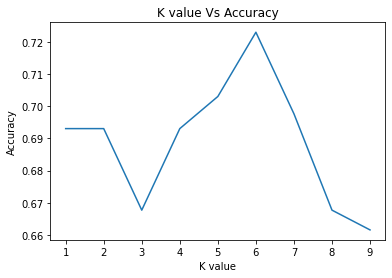

In [40]:
k = [1,2,3,4,5,6,7,8,9]  
plt.plot(k, accuracy)
plt.title('K value Vs Accuracy')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.show()

## Logistic Regression

In [41]:
dataset = []
with open('D:\Data\my.dat','rb') as f:
    while True:
        
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break  

In [42]:
def column(matrix, i):
    return [row[i] for row in matrix]
df = column(dataset,0)
output = column(dataset,2)

In [43]:
data = pd.DataFrame(df)
data.columns = ['mfcc1','mfcc2','mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12','mfcc13']
data['Gerne'] = output

In [44]:
scalar = StandardScaler()
x  = scalar.fit_transform(np.array(data.iloc[:,0:12],dtype = float))

In [45]:
arr = data.values
X = arr[:,:12]
Y = arr[:,13]

### Using RepeatedKFold

In [46]:
def func(model):
    rkf = RepeatedKFold(n_splits=24, n_repeats=2, random_state=1)
    my_score=[]
    for train_index, test_index in rkf.split(X):
         X_train, X_test = X[train_index], X[test_index] 
         y_train, y_test = Y[train_index], Y[test_index]
         model.fit(X_train,y_train)
         my_score.append(model.score(X_test,y_test))
    return my_score

Text(0, 0.5, 'accuracy')

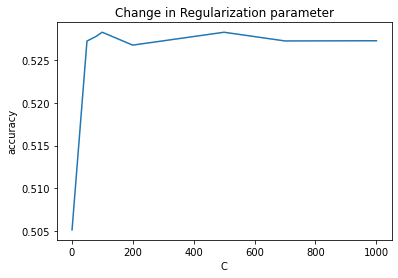

In [47]:
c = [1,50,80,100,200,300,500,700,1000]
logacc=[]
for i in c:
    model = LogisticRegression(solver = 'liblinear',random_state=0,C=i,penalty='l2',multi_class='ovr')
    my_score=func(model)
    logacc.append(np.mean(my_score))
plt.plot(c,logacc)
plt.title("Change in Regularization parameter")
plt.xlabel("C")
plt.ylabel("accuracy")

## Logistic with PCA

In [48]:
pca = PCA(n_components=13)
X_pca = pca.fit_transform(data.drop('Gerne',axis='columns'))
Y_pca = data['Gerne']

In [49]:
def func1(model):
    rkf = RepeatedKFold(n_splits=24, n_repeats=2, random_state=1)
    my_score=[]
    for train_index, test_index in rkf.split(X):
         X_train, X_test = X_pca[train_index], X_pca[test_index] 
         y_train, y_test = Y_pca[train_index], Y_pca[test_index]
         model.fit(X_train,y_train)
         my_score.append(model.score(X_test,y_test))
    return my_score

Text(0, 0.5, 'accuracy')

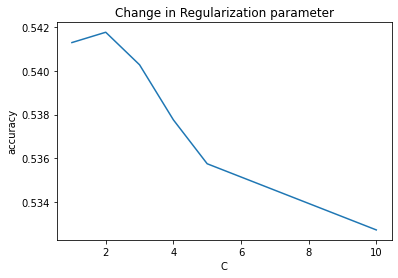

In [50]:
c = [1,2,3,4,5,10]
logacc=[]
for i in c:
    model = LogisticRegression(solver = 'liblinear',random_state=0,C=i,penalty='l2',multi_class='ovr')
    my_score=func1(model)
    logacc.append(np.mean(my_score))
plt.plot(c,logacc)
plt.title("Change in Regularization parameter")
plt.xlabel("C")
plt.ylabel("accuracy")

## Desicion Tree

In [51]:
def train_using_gini(X_train, X_test, y_train,i): 
  
    # Creating the classifier object 
    clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 100,max_depth=i, min_samples_leaf=10) 
  
    # Performing training 
    clf_gini.fit(X_train, y_train) 
    return clf_gini 

In [52]:
def tarin_using_entropy(X_train, X_test, y_train,i): 
  
    # Decision tree with entropy 
    clf_entropy = DecisionTreeClassifier( 
            criterion = "entropy", random_state = 100, 
            max_depth = i, min_samples_leaf = 10) 
  
    # Performing training 
    clf_entropy.fit(X_train, y_train) 
    return clf_entropy 

In [53]:
def prediction(X_test, clf_object): 
  
    # Predicton on test with giniIndex 
    y_pred = clf_object.predict(X_test) 
    print("Predicted values:") 
    print(y_pred) 
    return y_pred 

In [54]:
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
    return accuracy_score(y_test,y_pred)*100

### Train, Test and Validation Splitting

In [55]:
train, validate, test = np.split(data.sample(frac=1, random_state=42), [int(.6*len(data)), int(.8*len(data))])
train1 = train.drop('Gerne',axis='columns')
y_train = train['Gerne']
test1 = test.drop('Gerne',axis='columns')
y_test = test['Gerne']
val1 = validate.drop('Gerne',axis='columns')
y_val = validate['Gerne']

In [56]:
gini_test_acc = []
gini_val_acc = []
entropy_test_acc = []
entropy_val_acc = []
for i in range(1,15):
    clf_gini = train_using_gini(train1, test1, y_train,i) 
    clf_entropy = tarin_using_entropy(train1, test1, y_train,i) 
      
    print("Results Using Gini Index:") 
    y_pred_gini = prediction(test1, clf_gini) 
    gini_test_acc.append(cal_accuracy(y_test, y_pred_gini)) 
      
    print("Results Using Entropy:")
    y_pred_entropy = prediction(test1, clf_entropy) 
    entropy_test_acc.append(cal_accuracy(y_test, y_pred_entropy))

    y_val_gini = prediction(val1,clf_gini)
    gini_val_acc.append(cal_accuracy(y_val,y_val_gini))

    y_val_entropy = prediction(val1, clf_entropy) 
    entropy_val_acc.append(cal_accuracy(y_val, y_val_entropy))

Results Using Gini Index:
Predicted values:
[2 4 4 4 2 4 4 2 4 4 2 2 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 2 4 4 4 4 4 4 4 2 4 2 4 4 4 2 2 4 2 4 4 4 4 4 4 4 4 4 2 4 4 4 2 4 2
 4 4 4 4 2 4 4 4 4 2 4 2 4 2 4 4 4 4 4 2 4 4 4 4 4 4 4 4 2 4 2 4 4 4 4 4 4
 4 2 4 4 4 4 4 4 4 4 4 4 2 4 4 4 2 4 4 2 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 2 4
 4 2 4 4 4 4 4 4 4 4 2 4 4 4 4 4 2 2 4 4 4 2 4 4 4 2 4 4 4 4 4 4 2 4 4 4 4
 4 4 4 4 4 2 4 4 4 4 2 4 4 4 2]
Confusion Matrix:  [[ 0  8  0 16  0  0  0  0  0  0]
 [ 0 13  0  4  0  0  0  0  0  0]
 [ 0  6  0 14  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0  0  0]
 [ 0 10  0 12  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0  0  0]
 [ 0  1  0 23  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]]
Accuracy :  15.5
Results Using Entropy:
Predicted values:
[2 4 4 4 2 4 4 2 4 2 2 2 4 4 4 4 2 4 2 2 4 4 4 4 4 2 4 4 4 4 4 4 4 2 2 4 4
 2 4 4 2 4 4 4 2 4 4 4 2 4 2 4 2 4 2 2 4 2 4 4 4 2 4 4 4 4 4 2 4 4

Confusion Matrix:  [[ 5  0  0  0  0  1  1  0  0  2]
 [ 0 19  1  1  0  3  0  0  0  0]
 [ 2  4  7  2  0  2  1  1  1  0]
 [ 0  1  2  4  1  0  2  2  0  2]
 [ 3  0  6  2  2  1  1  0  0  3]
 [ 2  0  2  0  0  4  0  0  2  0]
 [ 5  0  2  0  1  0 20  0  0  3]
 [ 0  0  1  3  0  0  0 18  2  0]
 [ 2  2  5  2  0  2  0  2  7  0]
 [ 6  0  5  7  1  2  1  1  0  5]]
Accuracy :  45.5
Predicted values:
[ 1  2  8  6  5  4  6  6  7  5  2  4  8  8  8  1  7  9  4  1  1  2  8  2
  1  3  1  4  6  3  1  8  1  8  7  3  1  8  8  6  5  2  1  1  4  5  1  6
  8 10  3  8  6  1  1  5  8  1  2  3 10 10  3  5  2  2  5  6  1  7  6  8
  5  7  2  5  3  5  1  4  1  1  8  9  9  1  8  5  4  5  8  6  5  8  8  4
  1  1  1  2  8  7  1  4  8  1  2  3 10 10  9  1  7  6  8  2  2  5  7  2
  8  3  7  2  6  4  2  2  8  4  2  1 10  8  6  8  8  2  1  1  8  9  8  5
  2  7  5  8  1  1  7  9  8  3  1  1  1 10  8  2  2  1  9  9  8  7  1 10
 10 10 10  7  8  7 10  5  3  9  3  8  1  7  5 10  5  3 10  9  9  2  6  7
 10  7  6  7  6  9  7  5]
Confu

Predicted values:
[ 2  4  4  8  1  8  7  2  9  1  6  2  7  9  8  9  8  8  6  4  4  9  4  1
  9  7  9 10  7  8 10  8  5  3  2 10  7  3  7  8  6  4  7  7  1 10  6  7
  2  1  1  8  6  9  6  6  9  2  7  9  3  5  7  1  7  3  6  2  1  5  7  6
  1  1  6  3  7  1  1  1  1  9  9  2  9  6  8  1  9 10  3  8  4  1  8 10
 10  9  8  3  5  2  1  9  2 10  8  5  2  8  5  4  2  1 10  6  4  3  3  1
 10  1  8  1  8  8 10  1  9  9  6  4  8  8  3  9 10  4 10  2  9 10  7  1
  6 10  2  7  1  6  5  4  5  2  8  8 10  7  1  7  5  4  5  8  1  1 10  9
  2  6  4  2  9  1  2  7  8  8  1  7  2  7  4  2 10  3  5  4  8 10  2  7
  6 10  7  6 10  4  3  6]
Confusion Matrix:  [[12  2  2  0  0  4  4  0  0  0]
 [ 1 12  0  0  0  4  0  0  0  0]
 [ 4  1  1  1  1  2  0  3  2  5]
 [ 1  0  1  3  0  0  2  1  4  6]
 [ 0  1  1  0  4  2  4  4  4  2]
 [ 4  3  2  5  0  5  1  0  1  1]
 [ 2  0  0  0  1  0 11  0  0  1]
 [ 0  1  1  3  0  0  0 16  3  4]
 [ 4  1  1  2  5  2  1  1  7  0]
 [ 1  0  3  3  0  0  0  1  0  2]]
Accuracy :  36.5
Resul

Text(0, 0.5, 'accuracy')

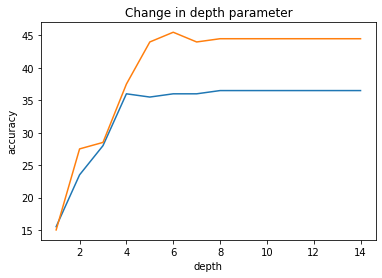

In [57]:
d = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#blue line for test
plt.plot(d,gini_test_acc)
#orange label for validation
plt.plot(d,gini_val_acc)
plt.title("Change in depth parameter")
plt.xlabel("depth")
plt.ylabel("accuracy")

Text(0, 0.5, 'accuracy')

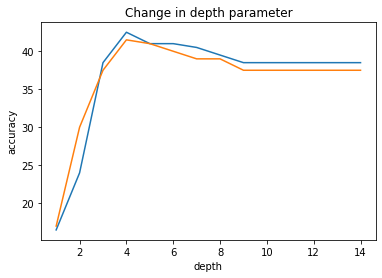

In [58]:
d = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#blue line for test
plt.plot(d,entropy_test_acc)
#orange label for validation
plt.plot(d,entropy_val_acc)
plt.title("Change in depth parameter")
plt.xlabel("depth")
plt.ylabel("accuracy")

## KMeans Algorithm

In [59]:
X = data[['mfcc1','mfcc2']]

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

In [61]:
wcss=[]
sil=[]
for i in range(2,30):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=64)
    
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Silhouette Score Method')

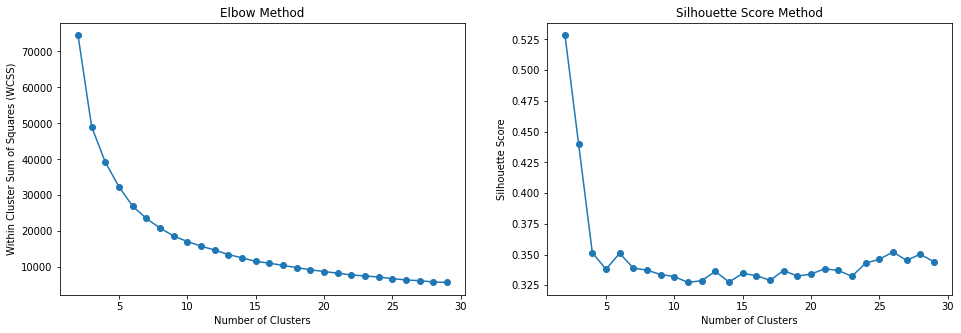

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,5))
x=np.arange(2,30)
ax1.plot(x,wcss,marker='o')data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA8EAAAFNCAYAAAAgpW2KAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Il7ecAAAACXBIWXMAAAsTAAALEwEAmpwYAABzc0lEQVR4nO3deXhcZfn/8fedfemStElLm6QrpSxlKZQdkUWgLEIV2RVwAf0Kil+Rr+AGsiiKouIPUVQEFFlkKRUKla2orC20UNpSaEtLm+5N0y1pmuX+/XFO2kk6M5mkmUyS+byua67MPGeZ+wxlnrnPs5m7IyIiIiIiIpIOMlIdgIiIiIiIiEhXURIsIiIiIiIiaUNJsIiIiIiIiKQNJcEiIiIiIiKSNpQEi4iIiIiISNpQEiwiIiIiIiJpQ0mwSDdiZpea2X8jXruZ7ZnKmDpLZ16LmS0xs091xrlERKT7M7OLzOxfEa931Clmdq+Z3Zy66KQjWv/m2c1zHWdmyzvjXJIelASLdLEwgas1sy0Rj/+X6rhgR4XkZvarVuVnheX3Jnie6Wb2laQEKSIivZKZHWNmr5rZRjOrMrNXzOxQAHd/wN1PTnWMkaLVdbt7wzesb2eb2SYzW2dmL5rZyN2PtuPC63QzO7BV+RNh+XEJnGNEuG9WsuIUaQ8lwSKp8Wl37xPxuDLVAUVYBJzbqqK6BPggRfGIiEgvZ2b9gKeA3wIDgDLgx0BdKuPqSmHyfD9wNdAfGAncCTR24nuYmXXk9/8HwMUR5xkIHAms7azYRLqSkmCR7u80M1sc3hG+rbnyMrMMM/uBmS01szVmdr+Z9Q+33WdmV4fPy8K7r1eEr0eHd9hj/f+/CpgDnBLuPwA4CpgSuZOZHRHesa82s3ea7wSb2S3AJ4D/F6WV+1Nm9mF4zJ1mZm1dS7j9C+G29Wb2/d37OEVEpBvaC8DdH3T3Rnevdfd/ufu7kFDX2WIze9rMNpvZG2Y2unmDmR1lZjPCFuYZZnZUxLYWw2vM7AYz+1vE64TrOjP7d3jYO2HZeeG+Z4Stu9XhuQ6IcQ0HAR+5+wse2Ozuj7n7x+F5Ms3se2a2KLzOt8ysIoFrnG5mt5jZK0ANMMrM9jaz58LfAwvM7Ny4/3XgAeA8M8sMX18APAFsj3ifDDO7NoxvvZk9Ev6GAGj+bKrDz+bIiON+YWYbzOwjMzs1onyomU0JY1xoZpdFbMu3oBv8BjObBxzaRvwiLSgJFun+PgNMAA4GzgK+FJZfGj6OB0YBfYDmhPNl4Ljw+SeBxcCxEa//4+5Ncd7zfnbe8T0feJKIu/FmVgY8DdxMcMf+O8BjZlbq7t8H/gNcGaWV+wyCiuoA4FzCRDvetZjZvsBdwBeAocBAoDxO7CIi0vN8ADSGN3FPNbPidh5/PkHLcTGwELgFdtzIfRq4g6D+uB142oKWzLjaW9e5e3M9e2BY9rCZjQfuAb4avv8fgClmlhvlLd8G9jazX5nZ8WbWp9X2bxMkn6cB/Qh+D9QkeI1fAC4H+hK03j4H/B0YFH52vwvr21hWAPOA5i7pFxP8Voj0DWASwe+MocAGgpZs2PkbpCj8bF4LXx8OLABKgJ8Df26+QQ48BCwPz/U54CdmdkK47XpgdPg4haDHmkjClASLpMbk8I5w8+OyOPv+zN2rwjvBvyaoAAEuAm5398XuvgW4Djjfgm7MLwPHWNDaeyxBxXJ0eNwnw+3xPAEcF7bGRqvoPg9Mdfep7t7k7s8BMwkq5nhudffq8FpeIrjr3da1fA54yt3/7e51wA+BeAm8iIj0MO6+CTgGcOCPwNqwFXBwgqd4wt3fdPcGglbLg8Ly04EP3f2v7t7g7g8C7wOfTuCcHa3rIl0O/MHd3whbuO8juKl8ROsd3X0xwQ3sMuARYF3Y2tmcDH8F+IG7Lwhbit9x9/UJXuO97j43/HwmAkvc/S/h/rOAx4Bz2riW+4GLzWxvgmT2tVbbvwZ8392Xh/X1DcDnLP444KXu/kd3bwTuA4YAg8MW7qOB77r7NnefDfyJnTfozwVuCX8fLSO4ASCSMCXBIqkxyd2LIh5/jLPvsojnSwnuiBL+XdpqWxYw2N0XAVsJfgR8gmCc1QozG0sCSbC71xLcVf4BMNDdX2m1y3DgnMhEnuDHy5B45yXoat2shqDFN+61hNt2fAbuvhVY38b7iIhID+Pu8939UncvB8YRfP//OsHDE61fCF+XJXDOjtZ1rc9xdatzVLCzLm/B3V9393PdvZSg/j4WaB4GVEEwb0driVxj5G+J4cDhrWK6CNijjWt5HDgBuBL4a5Ttw4EnIs45n2A8c7wbGTv+u7l7Tfi0T3hNVe6+OcY1tfhtwK7XLxKXZmgT6f4qgLnh82EEXZII/w6P2G8Y0ACsDl+/TNCKmuPulWb2MkF3oWJgdgLvez/wIkH3staWAX9191gt2J7A+SPFu5aVwD7NG8ysgKC7l4iI9FLu/r4FKxJ8dTdP1bp+gaCOeTZ8vhUoiNgWmQh2Rl23jKDF8pYE9m15cvcZZvY4wQ2B5nONBt5rtWtb19g61mXAy+5+UjvjqTGzZ4D/CeNobRnwpSg3zjGz1vG1ZQUwwMz6RiTCw4DK8PlKdv19JJIwtQSLdH/XmFlx2DXoKuDhsPxB4H/NbGTYVeonwMNhVycIkuAr2TkZxfTw9X/DbkdteRk4iWCmztb+BnzazE4JJ+rIs2CNvuaxuqsJxvYmKt61PAqcYcHSGTnAjei7S0SkVwknarq6uR4J67wLgNd389RTgb3M7EIzy7Jgsqp9CXpIQXBT+HwzyzazCQQ3j5t1pK5rXfZH4GtmdrgFCs3sdDPr2zrQsJ67zMwGha/3Bs5k52fwJ+AmMxsTnuuAcNxvW9fY2lPh/l8IrzvbzA41s31i7B/pe8An3X1JlG2/B25pTnjNrNTMzgq3rSUYypTQb4Owi/OrwE/Dz/0A4MsE/00g6C5+Xfj7qJxgPLJIwvRDUiQ1/mkt1wl+Is6+TwJvEVTUTwN/DsvvIeiO9G/gI2AbLSuBlwkmwGhOgv9LcLf73yQgHG/0grtXRdm2jGCSru8RVGzLgGvY+Z3yG4JxQBvMLJFxOjGvxd3nAlcQTOCxkmCijeWJXIOIiPQYmwkmSXrDzLYSJH7vESwX1GHhmNkzwvOsB/4POMPd14W7/JCgVXMDQc+nv0cc25G67gbgvrBL8LnuPhO4jGCyxw0Ek3ZdGiPcaoKkd46ZbSFoyX2CYF4PCCa8egT4F7CJ4PdAfgLX2Poz2UwwwdX5BC2uq4CfAdEm62p97Ap3jzVL928IVpL4l5ltJvhveHh4XA3BZGWvhJ/NLmOio7gAGBHG+ARwvbs/H277MUEX6I8IPo9o3bNFYjL39vZaFBEREREREemZ1BIsIiIiIiIiaUNJsIiIiIiIiKQNJcEiIiIiIiKSNpQEi4iIiIiISNpQEiwiIiIiIiJpIyvVAXS1kpISHzFiRKrDEBGRXuCtt95a5+6lqY6jp1PdLCIinSWRujntkuARI0Ywc+bMVIchIiK9gJktTXUMvYHqZhER6SyJ1M3qDi0iIiIiIiJpQ0mwiIiIiIiIpA0lwSIiIiIiIpI2lASLiIiIiIhI2lASLCIiIiIiImlDSbCIiIiIiIikDSXBIiIiIiIikjbSbp3g3TV5ViW3TVvAiupahhblc80pY5k0vizVYYmIiKQt1c0iItIeSoLbYfKsSq57fA619Y0AVFbXct3jcwBU2YqIiKSA6mYREWkvdYduh9umLdhRyTarrW/ktmkLUhSRiIhIelPdLCIi7aUkuB1WVNe2q1xERESSS3WziIi0l5LgdhhalN+uchERke7MzCaa2QIzW2hm10bZfqmZrTWz2eHjK2H5QWb2mpnNNbN3zey8iGPuNbOPIo45KJnXoLpZRETaS0lwO1xzyljyszNblOVnZ3LNKWNTFJGIiEjHmFkmcCdwKrAvcIGZ7Rtl14fd/aDw8aewrAa42N33AyYCvzazoohjrok4ZnbyrkJ1s4iItJ8mxmqH5gk2bnpqHuu3bqekTw4/OH1fTbwhIiI90WHAQndfDGBmDwFnAfPaOtDdP4h4vsLM1gClQHVyQo2tuQ7+8T/nsqGmnkF9c/neafuobhYRkZjUEtxOk8aX8eSVRwPw7ZO0BIOIiPRYZcCyiNfLw7LWzg67PD9qZhWtN5rZYUAOsCii+JbwmF+ZWW60Nzezy81sppnNXLt27W5cRlA3/+ELEwD4xTkHqm4WEZG4lAR3wND++eRmZfDRui2pDkVERCSZ/gmMcPcDgOeA+yI3mtkQ4K/AF929KSy+DtgbOBQYAHw32ond/W53n+DuE0pLS3c70PLiYAzw8g2aEEtEROJTEtwBGRnGyJJCPlq3NdWhiIiIdFQlENmyWx6W7eDu6929Lnz5J+CQ5m1m1g94Gvi+u78eccxKD9QBfyHodp10g/vlkZ1pLNtQ0xVvJyIiPZiS4A4aWVLIYiXBIiLSc80AxpjZSDPLAc4HpkTuELb0NjsTmB+W5wBPAPe7+6PRjjEzAyYB7yXrAiJlZhhDi/LVEiwiIm3SxFgdNLKkkOfmraa+sYnsTN1LEBGRnsXdG8zsSmAakAnc4+5zzexGYKa7TwG+aWZnAg1AFXBpePi5wLHAQDNrLrs0nAn6ATMrBQyYDXyta64o6BK9XC3BIiLSBiXBHTSypJCGJmf5hlpGlhSmOhwREZF2c/epwNRWZT+KeH4dwRjf1sf9DfhbjHOe0MlhJqy8qIAXF6xJ1duLiEgPoSbMDhpV2gdAk2OJiIh0E+XF+azdXMe2+sZUhyIiIt2YkuAOGhW2/i5eq3HBIiIi3UH5gGCG6MpqjQsWEZHYlAR3UHFhDkUF2ZocS0REpJsoLy4AtEySiIjEl7Qk2MzGmtnsiMcmM/uWmQ0ws+fM7MPwb3G4v5nZHWa20MzeNbODI851Sbj/h2Z2SUT5IWY2JzzmjnAmyi4zsqSQj9QSLCIi0i3sXCtYk2OJiEhsSUuC3X2Bux/k7gcRrCtYQ7CcwrXAC+4+BnghfA1wKjAmfFwO3AVgZgOA64HDCdYavL45cQ73uSziuInJup5oRpX00VrBIiIi3cSgvsFawWoJFhGReLqqO/SJwCJ3XwqcBdwXlt9HsIYgYfn9HngdKArXGjwFeM7dq9x9A/AcMDHc1s/dX3d3B+6POFeXGFVayKpN29ha19CVbysiIiJRaK1gERFJRFclwecDD4bPB7v7yvD5KmBw+LwMWBZxzPKwLF758ijluzCzy81sppnNXLt27e5cRwvNSyMtWa/WYBERke5AawWLiEhbkp4Em1kOcCbwj9bbwhZcT3YM7n63u09w9wmlpaWddt6RmiFaRESkWykvKlBLsIiIxNUVLcGnAm+7++rw9eqwKzPh3+ZV7SuBiojjysOyeOXlUcq7THMSrHHBIiIi3YPWChYRkbZ0RRJ8ATu7QgNMAZpneL4EeDKi/OJwlugjgI1ht+lpwMlmVhxOiHUyMC3ctsnMjghnhb444lxdIi87k7KifCXBIiIi3YTWChYRkbZkJfPkZlYInAR8NaL4VuARM/sysBQ4NyyfCpwGLCSYSfqLAO5eZWY3ATPC/W5096rw+deBe4F84Jnw0aVGlhRqrWAREZFuInKt4NGlfVIcjYiIdEdJTYLdfSswsFXZeoLZolvv68AVMc5zD3BPlPKZwLhOCbaDRpYUMnl2Je5OFy9TLCIiIq00rxW8rEqTY4mISHRdNTt0rzWypJDN2xpYv3V7qkMRERFJe4O1VrCIiLRBSfBuGlWqybFERES6i4wMo6xIyySJiEhsSoJ306iSYLzRR1omSUREpFsoL9YySSIiEpuS4N1UVpxPdqaxaN2WVIciIiIiBOOClQSLiEgsSoJ3U2aGMXxgoVqCRUREuony4nzWbdFawSIiEp2S4E4wqqRQY4JFRES6ichlkkRERFpTEtwJRpYWsnR9DY1NnupQRERE0l7zMkmaHEtERKJpc51gM5sAfAIYCtQC7wHPufuGJMfWY4wqKWR7YxOVG2oZNrAg1eGIiIikNbUEi4hIPDFbgs3si2b2NnAdkA8sANYAxwDPm9l9Zjasa8Ls3kaGM0Qv1uRYIiIiKTeob67WChYRkZjidYcuAI5297Pd/Sfu/id3/3/u/k13PwT4FTCma8Ls3rRWsIiI9ERmNtHMFpjZQjO7Nsr2S81srZnNDh9fidh2iZl9GD4uiSg/xMzmhOe8w8ysq66nmdYKFhGReGJ2h3b3O+Md6O6zOz2aHmpgYQ5987KUBIuISI9hZpnAncBJwHJghplNcfd5rXZ92N2vbHXsAOB6YALgwFvhsRuAu4DLgDeAqcBE4JmkXkwUWitYRERiidcd+jIzGxM+NzP7i5ltMrN3zezgrgux+zMzRpUUsljLJImISM9xGLDQ3Re7+3bgIeCsBI89hWB+kKow8X0OmGhmQ4B+7v66uztwPzApCbG3SWsFi4hILPG6Q18FLAmfXwAcAIwEvg38Jrlh9TwjtUySiIj0LGXAsojXy8Oy1s4Ob4A/amYVbRxbFj5v65xJp7WCRUQklnhJcIO714fPzwDud/f17v48UJj80HqWUaV9qKyuVWUrIiK9yT+BEe5+AEFr732ddWIzu9zMZprZzLVr13bWaXfYOUO0xgWLiEhL8ZLgJjMbYmZ5wInA8xHb8pMbVs8zsiS4L7BkvVqDRUSkR6gEKiJel4dlO4Q3v+vCl38CDmnj2MrwecxzRpz7bnef4O4TSktLO3wRsVQMCH6qLFOXaBERaSVeEvwjYCZBl+gp7j4XwMw+CSxOfmg9S3MS/JHGBYuISM8wAxhjZiPNLAc4H5gSuUM4xrfZmcD88Pk04GQzKzazYuBkYJq7rwQ2mdkR4azQFwNPJvtCotFawSIiEku82aGfMrPhQN9w0otmM4Dzkh5ZD9OcBC/WuGAREekB3L3BzK4kSGgzgXvcfa6Z3QjMdPcpwDfN7EygAagCLg2PrTKzmwh+EwDc6O5V4fOvA/cS9Bp7hhTMDA1Q2ieXnMwMdYcWEZFdxEyCzexQYJm7rwpfXwycDSwFbuiS6HqQwtws9uiXpxmiRUSkx3D3qQTLGEWW/Sji+XXAdTGOvQe4J0r5TGBc50bafhkZRplmiBYRkSjidYf+A7AdwMyOBW4lWOpgI3B38kPreYIZorekOgwRERFByySJiEh08ZLgzIiuTecBd7v7Y+7+Q2DP5IfW84ws1TJJIiIi3UV5cT6V6g4tIiKtxE2Czay5u/SJwIsR22J2o05no0oK2VBTz4at21MdioiISNorLy5g3Zbt1G7X8oUiIrJTvCT4QeBlM3sSqAX+A2BmexJ0iZZWRpVqciwREZHuorw4WCapslqtwSIislPMJNjdbwGuJpjh8Rh394hjvpH80HqekSV9ANQlWkREpBtoToK1VrCIiESKmQSHs0MXu/sT7h6Z1e0JWNIj64HKi/PJyjBNjiUiItINaK1gERGJJl536J8B86KUzwVuS044PVt2ZgbDBhRomSQREZFuQGsFi4hINPGS4L7uvrR1YVhWkryQerZRmiFaRESkW9BawSIiEk28JLg4zraCzg6ktwjWCt5KU5O3vbOIiIgkldYKFhGR1uIlwc+b2S1mtmP8rwVupOVySTGZWZGZPWpm75vZfDM70swGmNlzZvZh+Lc44tx3mNlCM3vXzA6OOM8l4f4fmtklEeWHmNmc8Jg7ImNNlZElfahraGLlpm2pDkVERCTtlRfns7xK3aFFRGSneEnw1cBoYKGZPWZmjwEfAnsB307w/L8BnnX3vYEDgfnAtcAL7j4GeCF8DXAqMCZ8XA7cBWBmA4DrgcOBw4DrmxPncJ/LIo6bmGBcSTOyJFwmaa0mxxIREUm18uIC1m/dTs32hlSHIiIi3US8JZK2uvv5wEkEyyTdC5zs7ue7e5sZnpn1B44F/hyeb7u7VwNnAfeFu90HTAqfnwXc74HXgSIzGwKcAjzn7lXuvgF4DpgYbuvn7q+HyzfdH3GulBkdrhWsccEiIiKpt2OtYHWJFhGRUFasDWb2JPBK+Jjm7tvbee6RwFrgL2Z2IPAWcBUw2N1XhvusAgaHz8uAZRHHLw/L4pUvj1Ie7VouJ2hdZtiwYe28jPYp7ZtLYU6mZogWERHpBiKXSRozuG+KoxERke4gXnfoPwJFwC3AajN71cx+YWafMbPBcY5rlgUcDNzl7uOBrezs+gxA2IKb9Bmk3P1ud5/g7hNKS0uT+l5mxkjNEC0iItItVIQtwVomSUREmsXrDv2Uu3/P3Y8jWBLpmwQtt7cBKxI493Jgubu/Eb5+lCApXh12ZSb8uybcXglURBxfHpbFKy+PUp5yI0v6KAkWERHpBkr65JKTlaEZokVEZId4LcGYWYmZnUnQGvwL4HPA88CX2jqxu68ClpnZ2LDoRGAeMAVonuH5EuDJ8PkU4OJwlugjgI1ht+lpwMlmVhxOiHUyQffslcAmMzsinBX64ohzpdSokkKWb6ihrqEx1aGIiIiktYwMo7xIyySJiMhO8cYEfwhsBB4jSERvTmRCrFa+ATxgZjnAYuCLBIn3I2b2ZWApcG6471TgNGAhUBPui7tXmdlNwIxwvxvdvSp8/nWCCbvygWfCR8qNKi2kyeHj9TUafyQiIpJiZcX56g4tIiI7xEyCgXuAI4Czgf2BcWb2GjDL3RNq4nT32cCEKJtOjLKvA1fEOM89YTyty2cC4xKJpSvtWCZp3VYlwSIiIilWXlzAv1asSnUYIiLSTcRMgt39p83PzWwv4CiCNXmPMbN17v7JLoivR2pOgjUuWEREJPXKi/N3rBVckBPv/r+IiKSDuGOCAcxsFHAYcDhBy/AgYHOS4+rR+uZlU9o3l8Vr29t7XERERDqb1goWEZFIMZNgM3vCzFYQjNU9gWCd3/PdvdTdz+iqAHuqkSVaJklERKQ7iFwrWEREJF6foL8Al7n7uq4KpjcZVVLI8/NXpzoMERGRtKe1gkVEJFK87tBV8RJgM+tnZt1uUqruYmRJIeu2bGdjbX2qQxEREYnKzCaa2QIzW2hm18bZ72wzczObEL6+yMxmRzyazOygcNv08JzN2wZ10eXEpLWCRUQkUryW4LPN7OfAswRdodcCecCewPHAcODqpEfYQ40q7QMEk2MdVFGU2mBERERaMbNM4E7gJGA5MMPMprj7vFb79QWuAt5oLnP3B4AHwu37A5PDFSGaXRSu4NAtaK1gERGJFG926P81swEESySdAwwBaoH5wB/c/b9dE2LPtHOG6C1KgkVEpDs6DFjo7osBzOwh4CxgXqv9bgJ+BlwT4zwXAA8lK8jOUlaczzJ1hxYREeK3BOPuVcAfw4e0w7ABBWQYfLRWk2OJiEi3VAYsi3i9nGAliB3M7GCgwt2fNrNYSfB5BMlzpL+YWSPwGHCzu3snxdxhFQMKmPue1goWEZEElkiSjsnJyqBiQAGLNUO0iIj0QGaWAdxOnKFPZnY4UOPu70UUX+Tu+wOfCB9fiHHs5WY208xmrl27thMjj668OJ+qrdvZWteQ9PcSEZHuTUlwEo0sKWSxWoJFRKR7qgQqIl6Xh2XN+gLjgOlmtgQ4ApjSPDlW6HzgwciTuntl+Hcz8HeCbte7cPe73X2Cu08oLS3dzUtpW/MySZXVGhcsIpLulAQn0aiSPny0bivdoBeYiIhIazOAMWY20sxyCBLaKc0b3X2ju5e4+wh3HwG8DpzZPOFV2FJ8LhHjgc0sy8xKwufZwBlAZCtxypRrmSQREQm1mQSb2TnhzJCY2Q/M7PFwjJC0YWRpIbX1jazeVJfqUERERFpw9wbgSmAawaSXj7j7XDO70czOTOAUxwLLmifWCuUC08zsXWA2Qctyt5hXZGcSrJZgEZF0F3dirNAP3f0fZnYM8CngNuAuWk2eIbsaFc4QvXjdFvbon5fiaERERFpy96nA1FZlP4qx73GtXk8n6CIdWbYVOKRTg+wkpX1yydVawSIiQmLdoRvDv6cDd7v700BO8kLqPZqXSdK4YBERkdQyM8qK89UdWkREEkqCK83sDwRLIEw1s9wEj0t7e/TLIz87k480Q7SIiEjKlRcXqCVYREQSSmbPJRgvdIq7VwMDgFhrBUqEjAxjREmhkmAREZFuoLw4X0mwiIi0nQS7ew2wBjgmLGoAPkxmUL3JKCXBIiIi3YLWChYREUhsdujrge8C14VF2cDfkhlUbzKypJCPq2qob2xKdSgiIiJpTWsFi4gIJNYd+jPAmcBWAHdfAfRNZlC9yajSQhqbnI+rNBGHiIhIKmmtYBERgcSS4O3u7oADmFlhckPqXZpniP5IM0SLiIiklNYKFhERSCwJfiScHbrIzC4DnqebLHzfE+xIgjUuWEREJKWa1wpept5ZIiJpLSveRjMz4GFgb2ATMBb4kbs/1wWx9QpFBTkMKMxhsZJgERGRlDIzzRAtIiLxk2B3dzOb6u77A0p8O2hUSSGL125JdRgiIiJpT2sFi4hIIt2h3zazQ5MeSS82UsskiYiIdAtBS7C6Q4uIpLNEkuDDgdfMbJGZvWtmc8zs3WQH1puMLC1kzeY6tmhdQhERkZQqLy5gQ0296mQRkTQWtzt06JSkR9HLjQonx1qybivjyvqnOBoREZH01TxDdOWGWsbuoRUfRUTSUZstwe6+1N2XArUEyyTtWC5JEjOqtA8AizQuWEREksTMClIdQ0+gtYJFRKTNJNjMzjSzD4GPgJeBJcAziZzczJaE3adnm9nMsGyAmT1nZh+Gf4vDcjOzO8xsYdjt+uCI81wS7v+hmV0SUX5IeP6F4bHWrqvvIsMGFGCmZZJERKTzmdlRZjYPeD98faCZ/S7FYXVb5cXBvQJNjiUikr4SGRN8E3AE8IG7jwROBF5vx3sc7+4HufuE8PW1wAvuPgZ4IXwNcCowJnxcDtwFQdIMXE8wNvkw4PrmxDnc57KI4ya2I64uk5edSVlRvpJgERFJhl8RDF1aD+Du7wDHpjSibqykTw65WRlqCRYRSWOJJMH17r4eyDCzDHd/CZjQ1kFxnAXcFz6/D5gUUX6/B14HisxsCEHF/py7V7n7BoKlmiaG2/q5++vu7sD9EefqdjRDtIiIJIu7L2tV1JiSQHoArRUsIiKJJMHVZtYH+DfwgJn9Bkg0m3PgX2b2lpldHpYNdveV4fNVwODweRkQWYkvD8vilS+PUr4LM7vczGaa2cy1a9cmGHrnGl3ah8VrtxLk6yIiIp1mmZkdBbiZZZvZd4D5qQ6qO9NawSIi6S2RJPgsgkmx/hd4FlgEfDrB8x/j7gcTdHW+wsxadM8KW3CTnhW6+93uPsHdJ5SWlib77aLatC1YjmHUdVM5+tYXmTyrMiVxiIhIr/M14AqCG8GVwEHha4lBawWLiKS3NpdIcvfIVt/7Yu4Y/djK8O8aM3uCYEzvajMb4u4rwy7Na8LdK4GKiMPLw7JK4LhW5dPD8vIo+3c7k2dV8tQ7QeO3A5XVtVz3+BwAJo2P2ngtIiLSJjPLBH7j7helOpaeJHKt4D65iawWKSIivUkis0NvNrNN4WObmTWa2aYEjis0s77Nz4GTgfeAKUDzDM+XAE+Gz6cAF4ezRB8BbAy7TU8DTjaz4nBCrJOBaeG2TWZ2RDgr9MUR5+pWbpu2gO2NTS3KausbuW3aghRFJCIivYG7NwLDzSwn1bH0JJFrBYuISPpJpCV4x0ryYbJ5FsFs0W0ZDDwRrlqUBfzd3Z81sxnAI2b2ZWApcG64/1TgNGAhUAN8MXz/KjO7CZgR7neju1eFz78O3AvkEyzblNDSTV1tRXX0SjZWuYiISDssBl4xsylEzNnh7renLqTuLXKt4LF79G1jbxER6W3a1QcoHMM72cyuZ+fSRrH2XQwcGKV8PcEyS9HOHXUMk7vfA9wTpXwmMC6h4FNoaFE+lVES3qFF+SmIRkREeplF4SMDaFdGZ2YTgd8AmcCf3P3WGPudDTwKHOruM81sBMHkW81dml5396+F+x7CzhvUU4GrvJvNCtm8VvCyKo0LFhFJR20mwWb22YiXGQTLI21LWkS90DWnjOW6x+dQW79zxYr87EyuOWVsCqMSEZHewN1/DBCu5IC7b0nkuHA88Z3ASQQrLMwwsynuPq/Vfn2Bq4A3Wp1ikbsfFOXUdwGXhftPBSbSzXpqlfTJIS87QzNEi4ikqURmh/50xOMUYDNBl2hJ0KTxZfz0s/tTFrb8ZhjcMmk/TYolIiK7zczGmdksYC4wN1yWcL8EDj0MWOjui919O/AQ0ev3m4CfkcAN8HDCy37u/nrY+ns/MCnBS+kywVrBWiZJRCRdJTIm+ItdEUhvN2l8GZPGl/Hseyv52t/eprgwN9UhiYhI73A38G13fwnAzI4D/ggc1cZxZcCyiNfLgcMjdzCzg4EKd3/azK5pdfzIMPneBPzA3f8TnnN5q3N2yzu+5cX5LK9Wd2gRkXSUSHfoO+Jtd/dvdl44vd8Jew9mYGEOD89YxvF7D0p1OCIi0vMVNifAAO4+PVyVYbeYWQZwO3BplM0rgWHuvj4cAzw5wdbnyPNfDlwOMGzYsN2Mtv3Ki/OZvay6y99XRERSL5Hu0HnAwcCH4eMgIAd4K3xIO+RkZfCZ8WU8P38167bUpTocERHp+Rab2Q/NbET4+AHBjNFtqQQqIl6Xh2XN+hJMPjndzJYQrAwxxcwmuHtdONEl7v4WwcRce4XHl8c55w7ufre7T3D3CaWlpQldaGcqLy6guqaezdvqu/y9RUQktRJJgg8AjnP337r7bwlmdj7I3e9z9/uSG17vdN6hFTQ0OU+8HfV3gYiISHt8CSgFHgceA0rCsrbMAMaY2chwneHzgSnNG919o7uXuPsIdx8BvA6cGc4OXRpOrIWZjQLGAIvdfSWwycyOCJdVvBh4stOutBPtWCtYyxWKiKSdRJLgYqBfxOs+YZl00JjBfRk/rIiHZy6jm60aISIiPYy7b3D3b7r7we5+iLt/y903JHBcA3AlMI1guaNH3H2umd1oZme2cfixwLtmNptg6aSvuXtVuO3rwJ+AhQQtxN1qZuhmzcskLa9SEiwikm4SWSf4VmCWmb0EGEHFd0Myg0oH502o4NrH5/D2x9UcMlz3FEREpGPM7DngHHevDl8XAw+5+yltHevuUwmWMYos+1GMfY+LeP4YQatztP1mEnSj7taaW4KXb9DkWCIi6abNlmB3/wvBbJFPEFR4R6ob9O4748ChFORk8siMZW3vLCIiEltJcwIMQcswoJkX2zCwUGsFi4ikq5hJsJkNN7P+AO6+imAJhBOBC8OxQ7Ib+uRmcfr+Q3jq3RVsrWtIdTgiItJzNZnZjumVzWw4oLE2bdBawSIi6SteS/AjQCGAmR0E/AP4GDgQ+F3SI0sD5x1awdbtjTz97spUhyIiIj3X94H/mtlfzexvwL+B61IcU4+gtYJFRNJTvCQ4391XhM8/D9zj7r8EvggclvTI0sAhw4sZVVrIIzPVJVpERDrG3Z8lWMrwYeBB4BB3n5baqHqG8uJ8tQSLiKSheEmwRTw/AXgBwN2bkhpRGjEzzp1QwcylG1i4ZkuqwxERkR6k1bCldcBW4GTgYg1bSszGmnqqa+oZee3THH3ri0yepaULRUTSQbwk+EUze8TMfkOwJNKLAGY2BNjeFcGlg88eXEZmhvEPtQaLiEj7aNjSbpg8q5Jn564CggHUldW1XPf4HCXCIiJpIF4S/C3gcWAJcIy714flexCMP5JOMKhvHifsPYjH3l5OfaMa2UVEJGEatrQbbpu2gPrGlvOH1dY3ctu0BSmKSEREukrMJNgDD7n7r9y9MqJ8lsYada7zJlSwbst2Xnx/TapDERGRnkPDlnbDiuroY4FjlYuISO/R5jrBknzHjS1lUN9crRksIiLtoWFLu2FoUX67ykVEpPdQEtwNZGVmcPYh5by0YA2rN21LdTgiItIzfAsNW+qwa04ZS352Zouy/OxMrjllbIoiEhGRrhIzCTazF8K/P+u6cNLXuRMqaHJ49K3lqQ5FRER6AA1b2j2Txpfx08/uT25W8FOorCifn352fyaNL0txZCIikmxZcbYNMbOjgDPN7CFajj3C3d9OamRpZmRJIYeNGMA/Zi7j68eNxszaPkhEREQ6bNL4Mt7+eAOTZ1XyyrUnpDocERHpIvGS4B8BPwTKgdtbbXOCSTikE517aAXf+cc7vPlRFYePGpjqcERERHq98uJ8Nm1rYGNtPf3zs1MdjoiIdIF4s0M/6u6nAj939+NbPZQAJ8Fp++9Bn9wsHtaawSIi0g5mlm9mGszaAeXFBQAs31CT4khERKSrtDkxlrvfZGZnmtkvwscZXRFYOirIyeLTBw5l6pyVbNpW3/YBIiKS9szs08Bs4Nnw9UFmNiWlQfUgFTuSYC2NJCKSLtpMgs3sp8BVwLzwcZWZ/STZgaWr8w6tYFt9E/98Z0WqQxERkZ7hBuAwoBrA3WcDI1MXTs9SXhwsiaQkWEQkfSSyRNLpwEnufo+73wNMBNQanCQHlvdn7OC+WjNYREQSVe/uG1uVeUoi6YGKCrIpzMlUd2gRkTSS6DrBRRHP+ychDgmZGeceWsE7yzfy/qpNqQ5HRES6v7lmdiGQaWZjzOy3wKupDqqnMDPKiwtYVqWWYBGRdJFIEvxTYJaZ3Wtm9wFvAbckN6z09pnxZWRnGg+rNVhERNr2DWA/oA74O7CRYBiTJKhiQL5agkVE0kgiE2M9CBwBPA48Bhzp7g8n+gZmlmlms8zsqfD1SDN7w8wWmtnDZpYTlueGrxeG20dEnOO6sHyBmZ0SUT4xLFtoZtcmfNXd3IDCHE7adzBPzKqkrqEx1eGIiEj3drq7f9/dDw0fPwDOTHVQPUl5cQGVG2pxVy9yEZF0kFB3aHdf6e5Twseqdr7HVcD8iNc/A37l7nsCG4Avh+VfBjaE5b8K98PM9gXOJ7jLPRH4XZhYZwJ3AqcC+wIXhPv2CudOqKC6pp7n561JdSgiItK9XZdgmcRQXpzP5rpgrWAREen9Eh0T3CFmVk4wsdafwtcGnAA8Gu5yHzApfH5W+Jpw+4nh/mcBD7l7nbt/BCwkmAXzMGChuy929+3AQ+G+vcInxpQytH+e1gwWEZGozOzUcPxvmZndEfG4F2hIcXg9SrmWSRIRSStJTYKBXwP/BzSFrwcC1e7eXDkvB8rC52XAMoBw+8Zw/x3lrY6JVb4LM7vczGaa2cy1a9fu5iV1jcwMY/+yfvz7g7WMvPZpjr71RSbPqkx1WCIi0n2sAGYC2wjm62h+TAFOiXPcDokOKzKzs83MzWxC+PokM3vLzOaEf0+I2Hd6eM7Z4WPQblxjl9i5TJLGBYuIpIOsRHYys2KgInJ/d3+7jWPOANa4+1tmdtxuxLjb3P1u4G6ACRMm9IgBP5NnVTL9g3VAsM5FZXUt1z0+B4BJ46Pm+iIikkbc/R3gHTMb7O73RW4zs6uA38Q7PmJY0UkEN5JnmNkUd5/Xar++BEOb3ogoXgd82t1XmNk4YBotb0Rf5O4zO3hpXa4ibAnWDNEiIumhzZZgM7sJeBe4A/hl+PhFAuc+GjjTzJYQdFU+gaBCLjKz5mS6HGhu3qwkSLQJt/cH1keWtzomVnmvcNu0BdQ1NLUoq61v5LZpC1IUkYiIdFPnRym7NIHjEh1WdBPBPB3bmgvcfZa7rwhfzgXyzSy3XVF3I/0Lsumbl6WWYBGRNJFId+hzgdHufpy7Hx8+TmjrIHe/zt3L3X0EQQX9ortfBLwEfC7c7RLgyfD5lPA14fYXPZimcQpwfjh79EhgDPAmMAMYE842nRO+x5QErqdHWFEd/W50rHIREUkvZnaBmf0TGGlmUyIeLwFVCZyizWFFZnYwUOHuT8c5z9nA2+5eF1H2l7Ar9A/D+T2ixd+thiqVFxdoTLCISJpIpDv0e0AR0FnTFH8XeMjMbgZmAX8Oy/8M/NXMFhJU3ucDuPtcM3sEmEcw0ccV7t4IYGZXEnTBygTucfe5nRRjyg0tyqcySsI7tCg/BdGIiEg39CqwEigh6KXVbDNBD67dYmYZwO3EaVU2s/0IWolPjii+yN0rw27UjwFfAO5vfWx3G6pUXpzPx+vVEiwikg4SSYJ/Cswys/eAHXd53T3hNQjdfTowPXy+mKALVut9tgHnxDj+FuCWKOVTgamJxtGTXHPKWK57fA619TvXCc7KMK45ZWwKoxIRke7C3ZcCS4EjzWw4MMbdnzezfCCfIBmOp61hRX2BccD0sDF3D2CKmZ3p7jPDFSCeAC5290URcVWGfzeb2d8J6vxdkuDuprw4n1cWrsPdidF4LSIivUQiSfB9BHd557BzlmdJsubJr26btoAV1bXkZmXQ5M7Re5akODIREelOzOwy4HJgADCaIJn9PXBiG4fuGFZEkPyeD1zYvNHdNxK0Mje/z3TgO2ECXAQ8DVzr7q9E7JMFFLn7OjPLBs4Ant/da+wKFcUF1GxvZENNPQMKc1IdjoiIJFEiSXCNu9+R9EhkF5PGl+1Ihhet3cLJv/o3v3nhA26etH+KIxMRkW7kCoLW1jcA3P3DRJYlcveGaMOKzOxGYKa7x5tn40pgT+BHZvajsOxkYCswLUyAMwkS4D928Lq6VOQySUqCRUR6t0SS4P+Y2U8JJp2K7A4dd4kk6VyjS/tw0eHDeOCNj7n0qBHsOahvqkMSEZHuoc7dtzd34Q1bYxMaYxttWJG7/yjGvsdFPL8ZuDnGaQ9J5L27m/KIZZIOKC9KbTAiIpJUicwOPR44AvgJ7VsiSTrZVSeOIT87k1ufeT/VoYiISPfxspl9j2CZopOAfwD/THFMPU75gJ0twSIi0ru12RLs7sd3RSDStoF9cvn68aP5+bMLeHXROo4arfHBIiLCtcCXCebu+CpBy+6fUhpRD9QvL5v++dlaJklEJA20mQRHjPVpwd1v7PxwpC1fOnokf3ttKT+ZOp8pVxxDRoZmsBQRSWfu3kQw7rZHjL3tzsqL81mmlmARkV4vke7QWyMejcCpwIgkxiRx5GVncs3EsbxXuYkn36ls+wAREenVzOwjM1vc+pHquHqi8uJ8tQSLiKSBRLpD/zLytZn9gmAmSUmRsw4s48///Yjbnl3AqeOGkJedmeqQREQkdSZEPM8DziFYLknaqaK4gJc/WKu1gkVEerlEWoJbKyBYg1BSJCPD+N5p+7Bi4zbueeWjVIcjIiIp5O7rIx6V7v5r4PRUx9UTlRfns62+ifVbt6c6FBERSaJExgTPYedSC5lAKaDxwCl21OgSPrXPIH730iLOm1DBwD65qQ5JRERSwMwOjniZQdAynMgSiNLKzmWSaihRvSoi0mslUkmeEfG8AVjt7g1Jikfa4dpT9+aUX/+H37zwITeeNS7V4YiISGpEDltqAJYA56YmlJ6tYkCQBC/fUMv4YcUpjkZERJIlZhJsZgVAvbsvDV+PBU4jqFyf6JLoJK49B/XlgsMqeOCNj7nkqBGMLu2T6pBERKSLaSnDzlNW3LxWsCbHEhHpzeKNCX6WcBZoM9sTeA0YBVxpZrcmPzRJxLc+tRf52Znc+sz7qQ5FRERSwMz6m9ntZjYzfPzSzPqnOq6eqE9uFsUF2VomSUSkl4uXBBe7+4fh80uAB939GwRLJGnCjW6ipE8u/3PcaJ6bt5rXF69PdTgiItL17gE2E3SBPhfYBPwlpRH1YBUDCtQSLCLSy8VLgj3i+QnAcwDuvh1oSmZQ0j5fOnokQ/rn8ZOp82lq8rYPEBGR3mS0u1/v7ovDx48Jem5JBwRrBaslWESkN4uXBL9rZr8ws/8F9gT+BWBmRV0RmCQuPyeT75w8lneXb+Sf765IdTgiItK1as3smOYXZnY0oKbMDiovLqByQy3uuqksItJbxUuCLwPWEYwLPtndm2+L7gv8IslxSTt9ZnwZ+w7px8+fXcC2+sZUhyMiIl3na8CdZrbEzJYC/y8skw4oL86nrqGJtZvrUh2KiIgkScwk2N1r3f1Wd7/K3d+JKH/V3f/aNeFJojIyjB+cvg+V1bXc++qSVIcjIiJdxN3fcfcDgQOA/d19fGS9Le1T0bxWsMYFi4j0WomsEyw9xFF7lnDC3oO488WFnDuhggGFOakOSUREkszMcoGzCXpuZZkZAO5+YwrD6rHKdyyTVMMhw7VWsIhIbxSvO7T0QNedujdb6hr4xM9fZOS1T3P0rS8yeVZlqsMSEZHkeRI4C2gAtkY8pAO0VrCISO8XtyXYzDKBn7n7d7ooHtlNc1dsIiPD2FoXjAuurK7lusfnADBpfFkqQxMRkeQod/eJqQ6ityjIyaKkT45miBYR6cXitgS7eyNwTLx9pHu5bdoCGlstk1Rb38ht0xakKCIREUmyV81s/1QH0ZuUFWutYBGR3iyRMcGzzGwK8A8iule5++NJi0o6bEV19Eo7VrmIiPRMZjYHcIK6/ItmthioAwxwdz8glfH1ZOXF+cyt3JjqMEREJEkSSYLzgPXACRFlDigJ7oaGFuVTGSXhHVqUn4JoREQkic5IdQC9VUVxAf+au4qmJicjw1IdjoiIdLI2J8Zy9y9GeXypK4KT9rvmlLHkZ2e2KDOD//3UmBRFJCIiSbK5jUebzGyimS0ws4Vmdm2c/c42MzezCRFl14XHLTCzU9p7zu6svDif+kZnjdYKFhHpldpsCTazvYC7gMHuPs7MDgDOdPebkx6dtFvz5Fe3TVvAiupaigtzqNq6ncXrNFGoiEgv8xZBz6xoTZUOjIp3cDj55Z3AScByYIaZTXH3ea326wtcBbwRUbYvcD6wHzAUeD78vUAi5+zuIpdJ2qN/XoqjERGRzpbIEkl/BK4D6gHc/V2Cii8uM8szszfN7B0zm2tmPw7LR5rZG+Ed4ofNLCcszw1fLwy3j4g4V6+925wMk8aX8cq1J/DRrafz9g9P4rwJFdz18iLeWLw+1aGJiEgncfeR7j4q/Nv6ETcBDh0GLHT3xe6+HXiIYKml1m4CfgZsiyg7C3jI3evc/SNgYXi+RM/ZrZUXFwCwTDNEi4j0SokkwQXu/marsoYEjqsDTnD3A4GDgIlmdgRBRford98T2AB8Odz/y8CGsPxX4X6t7zZPBH5nZpkRd7BPBfYFLgj3lVZ+9Ol9GT6ggG8/8g4ba+tTHY6IiHQCM9s7/HtwtEcCpygDlkW8Xh6WRb7HwUCFuz+d4LFtnrMn2NESXKVJJUVEeqNEkuB1ZjaaoGsVZvY5YGVbB3lgS/gyO3w4wQRbj4bl9wGTwudnha8Jt59oZkYvv9vcFQpzs/jVeQexatM2fjj5vVSHIyIinePq8O8vozx+sbsnN7MM4PaI9+lUZna5mc00s5lr165Nxlt0WF52JqV9c7VMkohIL5XI7NBXAHcDe5tZJfARcFEiJw9ba98C9iRotV0EVLt7c0ty5B3iHXeP3b3BzDYCA8Py1yNOG3lM67vNhycSVzoaP6yYb504hl8+9wEn7D1ox9hhERHpmdz9svDv8R08RSVQEfG6PCxr1hcYB0wP7kmzBzDFzM5s49h454yM/26C3xdMmDDBo+2TSuXF+eoOLSLSSyXSEuzu/imgFNjb3Y9J8DjcvdHdDyKoBA8D9u5ooLujO99t7kpfP35PJgwv5oeT32NZlSp2EZGezMwONbM9Il5fbGZPmtkdZjYggVPMAMaEc3XkEAw9mtK80d03unuJu49w9xEEN6TPdPeZ4X7nh/N5jATGAG+2dc6epKK4QC3BIiK9VCLJ7GMA7r7V3ZuXXHg0zv67cPdq4CXgSKDIzJpboCPvEO+4qxxu70+wPnGsu81t3cGOfP+73X2Cu08oLS1tT+i9SmaG8avzDsKBqx95h8ambnfjXUREEvcHYDuAmR0L3ArcD2wkbGGNJ+yVdSUwDZgPPOLuc83sxrC1N96xc4FHgHnAs8AV4Y3vqOfs4PWlVHlxPiuqa1VXioj0QjG7Q4cTbuwH9Dezz0Zs6ge0uV6AmZUC9e5ebWb5BMsl/IwgGf4cwRjeS4Anw0OmhK9fC7e/6O5uZlOAv5vZ7QTLMDTfbTbCu80Eye/5wIWJXni6qhhQwI1n7ce3H3mH37+8iCuO3zPVIYmISMdkuntV+Pw84G53fwx4zMxmJ3ICd58KTG1V9qMY+x7X6vUtwC2JnLMnKi8uoKHJWbVpG2VF+akOR0REOlG8McFjgTOAIuDTEeWbgcsSOPcQ4L5wXHAGwd3gp8xsHvCQmd0MzAL+HO7/Z+CvZrYQqCJchim8K918t7mB8G4zgJk1323OBO7pqXebu9pnxpfx4vtr+NVzH3DMniUcWFGU6pBERKT9Ms0sK2x9PRG4PGJbInN+SBw7Z4iuURIsItLLxKwk3f1J4EkzO9LdX2vvicP1hMdHKV9MMD64dfk24JwY5+rVd5u7mplxy6T9eXvpBr718Gye+sYxFObq95KISA/zIPCyma0DaoH/AJjZngRdomU3VAwI1gpevqFWs26KiPQyiYwJ/oyZ9TOzbDN7wczWmtnnkx6ZJFX/gmxuP+8glqzfys1Pz0t1OCIi0k7hDeKrgXuBY9y9efBqBvCNVMXVWwwtCkZ+aXIsEZHeJ5Ek+GR330TQNXoJwXJH1yQzKOkaR4wayFePHc2Dby5j2txVqQ5HRETayd1fd/cn3H1rRNkH7v52KuPqDXKzMhncL1fLJImI9EKJJMHZ4d/TgX+4u7pY9SLfPmkvxpX149rH3mXNpm2pDkdERKTbCJZJUhIsItLbJDIQ9J9m9j7BeKP/CWd9VrbUS+RkZfDr88Zzxm//wxf+/Aab6xpYWb2NoUX5XHPKWCaNL0t1iCIiIilRXpzPzKUbUh2GiIh0sjZbgt39WuAoYIK71wNbgbOSHZh0nT0H9eGMA4ayYPUWVlRvw4HK6lque3wOk2dFXXpZRESk1ysvLmDlxm00NDalOhQREelEbbYEm9nFEc8jN92fjIAkNV5btG6Xstr6Rm6btkCtwSIikpYqBuTT2OSs3Lhtx2zRIiLS8yXSHfrQiOd5BGsRvo2S4F5lRXX0Hu4rqjUrpoiIpKfy4p3LJCkJFhHpPdpMgt29xTILZlYEPJSsgCQ1hhblUxkl4R1alJ+CaERERFKvvDioA4PJsQamNhgREek0icwO3dpWYGRnByKpdc0pY8nPztyl/MhRA1IQjYiISOoN6Z+PGSzTWsEiIr1KImOC/wl4+DID2Bd4JJlBSddrHvd727QFrKiuZUj/PIoLs3n07UqGFOXz7ZP2aj0mXEREpFfLycpgSL88LZMkItLLJDIm+BcRzxuApe6+PEnxSApNGl/WYhKshsYmvv/Ee/z2xYWs3VzHzZPGkZXZkc4DIiIiPVN5cQHL1RIsItKrJDIm+OWuCES6n6zMDG49e38G9cvlty8uZN2W7fz2gvHk5+zabVpERKQ3Ki/O5/XF61MdhoiIdKKYzXpmttnMNkV5bDazTV0ZpKSOmXH1yWO58az9eOH91Xz+z29QXbM91WGJiIh0ifIBBazatI3tDVorWESkt4iZBLt7X3fvF+XR1937dWWQknoXHzmCOy88mDnLN3LO71/T0kkiIpIWyovzaXJYtTH6UoIiItLzxGsJPtTMTo1SfqqZHZLcsKQ7Om3/Idz3pcNYtXEbZ9/1Kh+u3pzqkERERJKqeZmkZZocS0Sk14g3y9HPgHlRyucBtyUnHOnujhw9kIe/eiQNTc7nfv8av3puAUff+iIjr32ao299kcmzKlMdooiISKepKC4A0AzRIiK9SLwkuK+7L21dGJaVJC8k6e72HdqPx//nKLIzjd+8sJDK6locqKyu5brH5ygRFhGRXmNI/zwyM0wzRIuI9CLxkuDiONsKOjsQ6VkqBhREXS6ptr6R26YtSEFEIiIinS8rM4M9+uUpCRYR6UXiJcHPm9ktZmbNBRa4EXgx+aFJd7c6xiQhmjRLRER6k/LifJZVqTu0iEhvES8JvhoYBSw0s8fM7DHgQ2Av4NtdEZx0b0OL8qOWD+yT08WRiIiIJE/FgAK1BIuI9CLxlkja6u4XACcB94aPk939fHff0jXhSXd2zSljyc/ObFFmwLot2/npM/Opa2hMTWAiIpIQM5toZgvMbKGZXRtl+9fMbI6ZzTaz/5rZvmH5RWFZ86PJzA4Kt00Pz9m8bVAXX1anKy/OZ/XmbarXRER6iay2dnD3xcDiLohFephJ48sAuG3aAlZU1zK0KJ9vnrAns5dv5A8vL+bfH6zj1+cdxNg9+qY4UhERac3MMoE7CW52LwdmmNkUd49cGeLv7v77cP8zgduBie7+APBAWL4/MNndZ0ccd5G7z+yCy+gS5cUFuMOK6m2MLClMdTgiIrKb2kyCReKZNL5sRzLc7LzD4FP7DOK7j73Lp3/7X/5v4li+dPRIMjIsxllERCQFDgMWhje7MbOHgLOIWB7R3TdF7F8IeJTzXAA8lMQ4U64iXCt4+YYaJcEiIr1AvDHBIh124j6DmfatY/nk2FJufno+F/3pDSo1YZaISHdSBiyLeL08LGvBzK4ws0XAz4FvRjnPecCDrcr+EnaF/mHkBJs9VfmA5rWCVY+JiPQGCSXBZpZpZkPNbFjzI9mBSc83sE8ud3/hEH5+9gG8u7yaib/+N5NnVeIerSFBRES6I3e/091HA98FfhC5zcwOB2rc/b2I4ovcfX/gE+HjC9HOa2aXm9lMM5u5du3aJEXfOQb3zSUrwzRDtIhIL9Fmd2gz+wZwPbAaaAqLHTggiXFJL2FmnHtoBUeMGsj/PjKbbz08m+fnr+ao0QO586VFO8YSX3PK2F26VYuISFJVAhURr8vDslgeAu5qVXY+rVqB3b0y/LvZzP5O0O36/tYnc/e7gbsBJkyY0K3vjmZlZjCkSGsFi4j0FomMCb4KGOvu65MdjPRewwYW8MhXj+T3Ly/iF9MW8NS7K3dsq6yu5brH5wAoERYR6TozgDFmNpIg+T0fuDByBzMb4+4fhi9PJ1gqsXlbBnAuQWtvc1kWUOTu68wsGzgDeD6pV9FFKooLWL5BLcEiIr1BIt2hlwEb23tiM6sws5fMbJ6ZzTWzq8LyAWb2nJl9GP4tDsvNzO4Il2l418wOjjjXJeH+H5rZJRHlh4RLNywMj+3x4456s8wM44rj96Skb+4u22rrG7lt2oIURCUikp7cvQG4EpgGzAcecfe5ZnZjOBM0wJVhHT4b+DZwScQpjgWWNU+sFcoFppnZu8BsguT6j8m9kq5RXpyvlmARkV4ikZbgxcB0M3saqGsudPfb2ziuAbja3d82s77AW2b2HHAp8IK73xquSXgtwTijU4Ex4eNwgi5Xh5vZAILu2BMIumG/FS7hsCHc5zLgDWAqMBF4JqErl5RZt7kuavkKTZwlItKl3H0qQf0ZWfajiOdXxTl2OnBEq7KtwCGdG2X3UF5cwJrNdWyrbyQvOzPV4YiIyG5IpCX4Y+A5IAfoG/GIy91Xuvvb4fPNBHeZywiWX7gv3O0+YFL4/Czgfg+8DhSZ2RDgFOA5d68KE9/ngInhtn7u/roHMy3dH3Eu6caGFuVHLc/KNN5auqGLoxEREWlbxYCg7tJKByIiPV+bLcHu/uPdfRMzGwGMJ2ixHezuzQNCVwGDw+exlmqIV748Srl0c9ecMpbrHp9DbX3jjrLsTCM/O5Oz73qVzx5cxrWn7s2gvnkpjFJERGSn8uKdyySNLu2T4mhERGR3xEyCzezX7v4tM/snQTfkFtz9zCiHRTtPH+Ax4Fvuvily2K67u5klfUZIM7scuBxg2DCt7pRqzZNf3TZtQYvZoU/adzB3vrSQP/3nI/41dzXfPHFPLj1qJDlZWs5aRERSq7w4aAnWMkkiIj1fvJbgv4Z/f9HRk4czQz4GPODuj4fFq81siLuvDLs0rwnLYy3VUAkc16p8elheHmX/XfSkZRjSxaTxZVFngv6/iXtz7oQKbnxqHj+Z+j4PzVjGDZ/ej2P3Kk1BlCIiIoHBffPIzjRNjiUi0gvEbGJz97fCvy9He7R14nCm5j8D81tNojWFnbNLXgI8GVF+cThL9BHAxrDb9DTgZDMrDmeSPhmYFm7bZGZHhO91ccS5pAcbUVLIPZceyj2XTqCpybn4nje5/P6ZLKuqYfKsSo6+9UVGXvs0R9/6IpNnxVvSUkREpHNkZBhlRflaJklEpBdoc0ywmR0N3AAMD/c3gp7Mo9o49GjgC8CccGkFgO8BtwKPmNmXgaUEawxCMDvlacBCoAb4IsEbVZnZTQTrGQLc6O5V4fOvA/cC+QSzQmtm6F7khL0Hc/SeJfz5vx/x/15cyHG3vYSZ0dAUNOZrfWEREelK5cUFagkWEekFElki6c/A/wJvAY1t7LuDu/+XIGGO5sQo+ztwRYxz3QPcE6V8JjAu0Zik58nNyuTrx+3JZ8aXccIvXm4xmRbsXF9YSbCIiCRbeXE+z89fneowRERkNyWSBG90d7WwSkoN6Z/Ptvro92BWVNfi7kROuiYiItLZKgYUsG7Ldmq3N5Kfo7WCRUR6qphjgs3sYDM7GHjJzG4zsyOby8JykS4Va31hB079zX+4/7UlbKyt79qgREQkbTTPEF1ZrXHBIiI9WbyW4F+2ej0h4rkDJ3R+OCKxRVtfOC87g08fOJT3V27mR0/O5SdT53PGAUO58PBhjK8oUuuwiIh0mp3LJNWy56C+KY5GREQ6KmYS7O7HA5jZKHdfHLnNzNqaFEuk08VaX7i5fM7yjfz9zY+ZMruSR99azt579OXCw4eRlWnc+eKiqMeIiIgkqqK4AEAzRIuI9HCJjAl+FGjd/fkfwCGdH45IfLHWFwbYv7w/Py3fn++fvg9TZq/gwTc/5kdPzm2xj2aUFhGRjirpk0tOVoZmiBYR6eHijQne28zOBvqb2WcjHpcCeV0WoUg79cnN4sLDh/HPbxxDad/cXbbX1jdyy9T5BBOSi4iIJCYjwygvymeZWoJFRHq0eC3BY4EzgCLg0xHlm4HLkhiTSKdZt7kuavnazXUc94vpnL7/EE4/YAj7Dumn8cMiItKm8gFaK1hEpKeLNyb4SeBJMzvS3V/rwphEOs3Qonwqq3f9sVKUn82wAQX84d+L+d30RYwqKeT0A4KEeOzgvpgZk2dVxhx/LCIi6am8OJ/3KjemOgwREdkNMZNgM/s/d/85cKGZXdB6u7t/M6mRiXSCaDNK52dncsOZ+zFpfBlVW7fz7HureHrOCu58aSG/fXEhew7qw+iSQqZ/sJa6hiZAY4lFRCRQXpxP1dbtbK1roDA3kalVRESku4n37T0//DuzKwIRSYa2ZpQeUJjDhYcP48LDh7F2cx3Pzl3FU++sYNq81bucq7a+kdumLVASLCKSxsp3zBBdy9g9tEySiEhPFC8JHm1mhwEPuHtDVwUk0tnizSgdqbRvLl84YjhfOGI4I699mmjTZlVW1/L428v5xJjSqJNuiYhI71YRrhW8fEONkmARkR4qXhJcDvwa2NvM5gCvAK8Cr7p7VRfEJpIyscYSZxh8+5F3ANi/rD/HjS3lk3uVclBFEVmZwWTrGkssItJ7RbYEi4hIzxRvYqzvAJhZDjABOAr4InC3mVW7+75dE6JI14s1lvgnk8YxZo++TF+whukL1u4YR9wvL4tP7FVK37wsJr9dyTaNJRYR6ZVK+uSQl53BsiotkyQi0lMlMqNDPtAP6B8+VgBzkhmUSKq1NZZ4XFl/rjxhDBtr6vnvwnVMX7CGlz9Yy5ooSzJpLLGISO9hZpQXa5kkEekZ1EMxunizQ98N7EewLvAbBF2hb3f3DV0Um0hKJTKWuH9B9o6lldydUddNjTmWeN6KTewzpK/WIxYR6cEmz6pkWVUNC9ds4ehbX0z6D0r9gBWRjpo8q7JFz0b1UNwpI862YUAusAqoBJYD1V0Qk0iPZGYMLcqPuf20O/7DCb98mZ8/+z7vVW7EPVq6LCLSdcxsopktMLOFZnZtlO1fM7M5ZjbbzP5rZvuG5SPMrDYsn21mv4845pDwmIVmdof1ojt/zT8oWy+fN3lWZVLfr7K6Fu+C9xOR3uW2aQtaDO2DnT0Uk2HyrEqOvvVFRl77NEff+mK3/q6KNyZ4Ylhx7UcwHvhqYJyZVQGvufv1XRSjSI8Rayzx907fm0zL4Jn3VvKHfy/md9MXUTEgn9PGDeG0/YeweO0WfvGvD3SnX0S6jJllAncCJxHc6J5hZlPcfV7Ebn9399+H+58J3A5MDLctcveDopz6LuAygl5kU8P9n0nKRXSxeD8ok/Gd3dXvJyK9x8aa+qiTvAKsiFG+O3paq3PcMcEeNFW9Z2bVwMbwcQZwGKAkWKSVtsYSX3j4MDZs3c6/5q1i6pxV/Pm/H/GHfy/GYEc36u7+pSEivcZhwEJ3XwxgZg8BZwE7kmB33xSxfyFEHfGxg5kNAfq5++vh6/uBSfSSJDjWD8dk/KBMxfuJSM9Xs72Bv7yyhN+/vCjmPrnZGTt+p3aWnnbTLt6Y4G8StAAfBdQTLo8E3IMmxhKJqa2xxMWFOZx36DDOO3QYG2vq+eQvXqK6pr7FPrX1jfzwyfcY0j+Pg4YVkZuVmeywRST9lAHLIl4vBw5vvZOZXQF8G8gBTojYNNLMZgGbgB+4+3/Ccy5vdc7u9+ung2Itnzekf15S3q9/QfYu9UNzHCIikeobm3hoxjLueOFD1m6u41P7DOLg4cX89oWFLZLTrAyjobGJT93+Mt/61Bi+ePRIsjPjjZBtW11DY5e2OneGeC3BI4B/AP/r7iu7JhyR9NK/IJuNUX7gAGze1sB5d79OTlYG4yuKOHzUQI4YOYDxw4rJzwmSYk2YIiLJ5u53Anea2YXAD4BLgJXAMHdfb2aHAJPNbL/2nNfMLgcuBxg2bFgnR50c0Ya8AAwfWIC7d+rEh68uWsem2noyDJoi2t8zDL590phOex8R6dmampx/vruC25/7gKXrazh0RDF3XXQwE0YMAGBo//xdfiseMryYH/9zLj+Z+j6PvrWcmyftz2EjB7T7vatrtvPAGx9z76tLYu6TmWE8N281n9pnULeaHNbSbXKeCRMm+MyZM1MdhsgOR9/6YsyWhR+fuR9vfFTFGx+tZ96KTTQ5ZGcaB5QXUVyQzb8/WMf2xqYdx+RnZ/LTz+6vRFiki5jZW+4+IdVxdISZHQnc4O6nhK+vA3D3n8bYPwPY4O79o2ybDnyHYCLNl9x977D8AuA4d/9qvFh6Ut3c+ubjPkP68vz8Ndzw6X259OiRnfIeC9ds5rO/e5XB/fL44jEjuPPFRayorqV/fjbVtfWcddBQfnXuQWRkdJ8flCKSXK2/e75z8l4UFebw82cXMH/lJvbeoy/fnbg3x40tTTjZfG7eam6YMpfK6lrOPric7522NwP75LZ53Mfra/jzfxfzyMzl1NY3cuxepew3pB/3vvoRtfU7f5fmZGbQvyCLtZu3c+SogXz/9H0YV7ZLFdLpEqmblQSLpFjriQQgejK7aVs9M5dU8cbiKt74qIrZy6qjnm9I/zxeu+7EZIctIvT4JDgL+AA4kSB5nQFc6O5zI/YZ4+4fhs8/DVzv7hPMrBSocvdGMxsF/AfY392rzOxN4JvsnBjrt+4+NV4sPblubmpyvvq3t3hh/mru/eJhHLtX6W6db92WOj7zu1eo3d7EE18/iooBBS22/276Qn7+7AIuPnI4Pz5zv27VsiIiyRHtt2JzL5FhAwq4+uS9+PQBQzt0Y6xmewO/fXEhf/z3Ygpzs/i/iWO54NBhTHlnxS4tyMMHFvDH/yzm2fdWkZlhnHlgGV/5xEj2GdJvR5ytjzn9gCE8+ObH/Pr5D9lQs53PjC/jmlPGMqR/8oZ1KAmOoidXtNJ7daRb88hrn445Q82E4cUcOXogR44ayMHDi8nLbjmmWN2oRTpHT06CAczsNODXQCZwj7vfYmY3AjPdfYqZ/Qb4FMHcIBuAK919rpmdDdwYljcRJMf/DM85AbgXyCeYEOsb3saPjZ5eN2+ta+Dsu16lsrqWJ75+NHsO6tOh82yrb+SCP77O/JWbeOjyIzmoomiXfdydnz7zPnf/ezHfPHEM3z5pr92MXkS6u1i9BvvnZzPj+58iJ2v3xvQCfLh6Mz988j1eX1xFxYB81myq27EcHOxMuvvmZfH5I4Zz6VEjGNwv8fkQNm2r586XFvKXV5aQYXDZJ0bx1U+Opk9u3HmaO0RJcBQ9vaIVaRbrC7FPbhajSwuZU7mRJmfHmOKjRpdw5OiBfLx+Kz98cm6bLc8i0raengR3F72hbl6+oYZJd75Cn9wsJl9xNEUFOe06vqnJ+caDs5j63kruuugQJo7bI+a+7s53H3uXR2Yu50dn7MuXjumcbtgi0n24O4vWbmX6gjXc/PT8qPsY8NGtp3fqe06eXcnVj7zTYi6CZv3zs3jl2hN3K3FdVlXDbdMWMOWdFZT0yeXqk/ciN9P45XMfdlrjjJLgKHpDRSsCbXej3rStnhkfVfHaovW8tng981ZuIt7/7mVF+bxy7Qkxt6v1WGRXSoI7R2+pm99aWsUFd7/BhBHF3Pelw9o14+qtz7zP719exPdP24fLjh3V5v4NjU1c+fdZPDt3Fb8850DOPqR8d0IXkS4U6zfV5m31vLpoPS9/sJaXF6zd0diRlWE0RMlK2/rt1lGxeht2ZtI96+MN3PL0fGYu3dBiqVDY/cYZJcFR9JaKVgTal5hW12znjY+q+Opf34p5vvHDihg2oIBhAwqoiPj7xqL1fH/ye2o9FmlFSXDn6E1186NvLec7/3iHLxwxnJsmjUvomAff/JjrHp/DRYcP4+ZJ4xIe51vX0MiX7p3B64ur+P3nD+GkfQfvTugi0gWiNWJkZRjDBxawdH0NDU1OYU4mR+9ZwnFjB3HsXiXMXLIhofljOkus3oadnXS7O4fc9BxVUVZK2Z33SqRu7vxO2CLSZdpakzhSUUEOp+y3B2Ux1rksyMmkICeTtz/ewFPvrqQxWj+YCLX1jdz67Pttvr9akEUknXzukHI+XL2ZP/x7MXsN7sMXjhwRd///fLiWH0x+j0/uVdruia5yszL5wxcmcNEfX+eKv7/NfV88jCNHD9zNKxCRZLpt2oJdlllraHKWrq/hsmNH8cm9Sjl4WHGLcb7lxQU7ju2K31PRloPLz87kmlPGdur7mBkbYiwVmuz1hZOWBJvZPcAZwBp3HxeWDQAeJliDeAlwrrtvsOAb/zfAaUANcKm7vx0ecwnBuoQAN7v7fWH5IeyceGMqcFVbE2+ISOwvtp98ZufdxPrGJlZWb2PZhho+rqrhusfnRD3Xqo3bOOSm5xgzuA9jBvVlr8F9GDO4L3sN7suAwpxd7nZWVtfuOJcSYRHprf5v4t4sXLOFG/45j5ElfThmTEnU/Ras2szX//Y2Ywb14f9dOJ6sdnSfbtYnN4t7v3gY5/zhNS67fyYPXnYE+5cnfwkSEemYWMldY5Pz3Yl7xzyuPQ0fu6v5fboi6R4ao3FmaFHyZo+GJHaHNrNjgS3A/RFJ8M8JllS41cyuBYrd/bvh7JTfIEiCDwd+4+6Hh0nzTGACQVfxt4BDwsS59RIMd7j7M23F1Zu6XIl0VHtbZ2PPSpjFqeOG8MHqzXy4egub6xp2bCvpk8OmbQ1sj5hZsFmyxrCIdDV1h+4cvbFu3lLXwNm/e5WVG2uZfMXRjCptOWP0ms3b+Mydr1Lf2MTkK47e7R98KzfW8rm7XqO2vpF/fO1IRpd2bIZqEUmedVvqOOInL3Tp+N7uLtGlQtsj5WOCzWwE8FREErwAOM7dV5rZEGC6u481sz+Ezx+M3K/54e5fDcv/AEwPHy+5+95h+QWR+8XTGytakWRL5AvK3Vm1aRsfrN7Ch6s388HqzTwyc3nMc543oYLRgwrZc1AfRpf2oby4gMyI9e3UjVp6AiXBnaO31s3Lqmo4685XKMrP5omvH03/gmwgWJfz/LtfZ+GaLTzy1SMZV9Y5LbcfrdvKOb9/lYbGJnKzM1mzqU7fnyLdxOpN27joT2+wZN0WMiyD7Y07GwnSfZ6Vzv7N1x3HBA9295Xh81VA8wwOZcCyiP2Wh2XxypdHKReRJEikW4yZMaR/PkP65/PJvUoBeGXh+qgtyDmZGbzw/moenrl9Z1lWBqNKChk9qA8NDU28uGAN9Y3BTTp1oxaRnqhiQAG///whXPSn1znn96+yZXsDK6u3kZuVwbaGJv58yYROS4ABRpYUcslRI/jlvz6A2qBnjr4/Jd10x5voyzfUcNGf3mDd5joe+MoRrNy4rdvFmEpd2dW7WcomxnJ3N7MuGcNrZpcDlwMMGzasK95SpNfpyBdUrPHHzXc7q2u2s2jtFhau2cKitVtZuGYL71VuZOn6ml3OVVvfyA8mz2FbfeOO1uPiwpbrcHbHik9E0tthIwdw9sHlPDRj5z39bQ1NZGcam7c1xDmyYx56c9kuZbX1jdz89DyO3auUAYWx1y/Wd6j0dB2diySZ//aXrt/KhX98g03b6vnrVw7n4GHFbcYjydfVSfBqMxsS0R16TVheCVRE7FcellUSdImOLJ8elpdH2T8qd78buBuCLle7dwkikqi2WpCLCnI4ZPgADhk+oMVxsdan21LXyLURk3QNLMxhdJgQ125vYOqcVTu6F6n1Q0S6i/98uG6XsvpG57ZpCzr9+ynWpDvrtmzn4Jueo6ggO+h1U9qHUaV9GF1ayKjSPryzbAM/mDxXExlG0E2BXXXnz8TdueXp+bvMvFxb38gPJ7/H9sYmyovzqSguYEj/vB0T0SVzEs+FazZz4R/foL6xiQcvO6JTe37I7unqJHgKcAlwa/j3yYjyK83sIYKJsTaGifI04CdmVhzudzJwnbtXmdkmMzuCYGKsi4HfduWFiEhiOtKCHHumwDwevvzIsOU4aEFeuGYLz7y3kuooU+zX1jfy/SfmsHZzHRUD8ikvDtY97p+f3WK/7lypi0jPFysxTcYSILG+PwcW5vA/x41m8bqtLFqzhekfrOUfb8WetwGC79BkJOo9gVY32FV3/Uw21tTzxKzlPDRjGWu31EXdZ3NdA//36Ls7XmdmGEP651FenM+7yzdGTZx399/+/JWb+Pyf3sDMeOjyIxm7R98On0s6XzKXSHqQoBW3xMyWA9cTJL+PmNmXgaXAueHuUwlmhl5IsETSFwHCZPcmYEa4343uXhU+/zo7l0h6JnyISC8Qqxv1/52yNxUDgkT2+L0HtTgmVuvx1u2N3DJ1fouyfnlZwXmKC6hraOC/C9d3aPyxkmcRSURXLgES6/vzh2fsu8v306Zt9SxeGyTFV//jnajnq6yu5d3l1exf1r9daxj3dNHWck32TYHuXqf8/Nn3u/wzicXdefOjKh6asYypc1ZS19DE/mX9KcrPprp215viQ/vn8dDlR7JsQw3LN9SwrKqW5RtqWL6hlprtjVHeYfduUr27vJqL73mT/OxMHvjK4bvMDi+pl7Qk2N0viLHpxCj7OnBFjPPcA9wTpXwmMG53YhSR7qkj69PF+pFZVpTP1G9+gmUbalhWVRP+rWXZhho+XLOZRWu37nJMbX0j1zz6Ds++t4qy4nzKivJ3/K0oLqBffhZPzl7RLe+Ii0j3EysxveaUsZ3+Xu35/uyXl81BFUUcVFHE7c99EPU7FODM//cKQ/vnccq4PThlvz04dMSAFrP590Zd2XoP3beVtdn8lZtYsXFb1G2V1bU8+94qTtxnENkdWOs6lmg3BT4xpoTH3g5afRev3Urf3CzOmVDO+YcOY1xZ/5irWfzfxL0ZNrCAYQMLdnmfWMtAYvDTZ+bzhSOGU16863GxvLW0ikvvmUH/gmwevOwIKgYkfqx0naQukdQd9dZlGETSXUfXmYvVggwwurSQyupattW3XOu4T24W2+obo67zN6R/Hq9dt8u9vhZxduc7/dI+WiKpc6RD3dzd/9+P9R36g9P3IScrg2lzV/HvD9exvaGJgYU5nLTvYE4ZtwdHjR7IM3NWdetra68tdQ0cdsvzUVsIB/fL5Y3vfarT3zNWIpbqtWPdnb+8soRbn3mfhqYmolR7ZBg0OQzqm8t5h1Zw3qEV7Uoao4n27zHTwAne65DhxZx/aAWnHzCEgpysXY5tz7/HaO+Vk5XB3nv0Ye6Kzbg7J+4zmEuPGsFRowfG7RHx6qJ1fOW+mQzul8cDXzk8Kb09pG0pXye4O0qHilYkXXXkR2ZbPzzcnaqt26msrqVyQy2V1bUs31DLva8uiXnOvnlZVBQXUDEgn2Fh9+2K4gI+WL2JXz3/YYukOtG1Abv7D+h0pSS4c6hu7h7a+p7ZUtfA9AVrmDZ3NS/OX83W7Y3kZhoNTdAY8XuyJ695+tqi9Vzz6Dss31BLVobtcrMzPzuD333+EI4fOyjGGTom3g3Zr35yFKNL+jCqtJCRJYUMKMzZkYgls25Yt6WO7/zjHaYvWMuJew/i+L1LueXp93e5UXLLpP3ok5fN39/8mJc/WAvAcXuVctHhwzlubClPvbsy4RgbGptYUb2Nz/zuFdZv3b7L9sLcTJ74+tHsNbhzx9fG+hxXVNfyt9eX8tCMZVRt3c6eg/pwyZHD+ezB5RTmZrU4bkBhDtU12xk9qA9/+8rhDOqb16kxSuKUBEehilZEInW0BTlW8twvL4tJ48vCrte1LKuqoa6hKcoZdirMzeRrx46mqCCbooIcigtywufZFBfk8K+5q/jeE++1O8bm61PynDxKgjuH6uaeZ1t9I68uWseVf58VtcU0LzuDrxwzilHh7NOjSgvpl7dzUsLu9t1Uu72Rnz37Pve+uoThAwv4xTkHUrmhtkWMXzx6BI+9Xcn7qzbxjRPGcNWJY3a7W3hDYxP3vrqEW56eHzUJzsowMsx2rHwA0D8/m1GlhWSZMWtZdYtEvbNuQExfsIbv/ONdNm2r5wen78MXjhiOmbX5321ZVQ0Pz1jGwzOXsXZzHf3zs9ha17LnVF52BledOIY9B/Vl6fqtLF1fw9KqGj5ev5XlG2qj9rJqZsBHt56+W9fWEdvqG3nq3ZXc9+oS5lRupG9uFuOHFfHGR1Ut6ngDbpo0js8fMbzLY5SdlARHoYpWRFrryI+xRJNnd2ft5jqWbajh7Lte69S4++ZmcfXJe1FcmMPAwlyKC7N3/M3Nyuxwgi+JUxLcOVQ391zxWjAzM4zGiISmpE8uo0oLyTSYsWRDUpK3jnhraRVXP/IOS9bXcMmRw/nuqXvv0sW22bb6Rn4w+T0efWs5x+5Vyq/POyju2svxvLOsmu89MYe5Kzaxzx59Wbxua4uEqvkzOeOAIVRW17J47VYWr9vK4rVbWLx2K298tD5q9+Td6bJd19DIz59dwJ//+xFjB/fljgvGd2hW4/rGJl6Yv5qrHprd5o3gvnlZjBhYyLCBBQwfUMCIgYX8fNr7rNuya0twd+gePmtZNfe9uoQnZ6+Iuk+qY5TE6uauXiJJRKTb6cgyTolOPmNmDOqXx6B+eZTFmbzrpe8cR3Xtdqpr6tmwdTvVtfVU12xnQ009tz7zftQYNtc1cMM/50Xd1ic3i9r6xhY/QCGY9Ovmp+dxQHl/hvTPJz8nc5dju1sLjYh0X/EmJXzpO8fxcdVWFq3dGiRwa7eweN1WZn68YZfkrba+kZ9Pe79Lv2u21Tdy+3Mf8Mf/LKasKJ+/X3Y4R40uiXtMXnYmt33uAA4ZXsz1T87l07/9L7+76GAOrChK+H03b6vnF9MWcP/rSyntk8vvLjqYU8ftwZOzV8T87h0+sJDhAws5PuI8I699Our5V2+q45zfv8qZB5Vx2rg9GNgnN6G4Fq7ZzDcenM38lZu45MjhXHfaPuRl71pHJCI7M4OJ44awveHtmPs88fWjGDGwkKKC7F3G2eZkZXTZZHLtYWYcPKyYg4cVM2X2iqg3gJI1eZp0LiXBIiId1N7kOd4MsTlZGQzqmxd1DNFfX1sac93kp77xCaq21rF+y3Y21Gxn/dbtbNga/P3LK0uixrFuy3ZO+OXLABQVZDOkfz5D++exR/88qmu28695q7VklIgkpK3vtT0H9WXPQS1bEmMlbyuqt3HPfz/icxPKW3SdTobZy6q5+pHZLFq7lQsOG8b3T9+HPrmJ/Sw2My44bBj7De3H//ztbc75/Wtcf+a+XHjYsLiTJrk7z763ihv+OZc1m+u4+IjhXH3K2B3X2t46JdYNiH55WWysreeHk9/jhilz+cSYEs46aCgn7bvHjmts+X2dx1F7lvDPd1ZQkJPFny+ZwIn7DE44jo7EWFaUz/hhxTGP68gqEV2tK5c+k86n7tAiIl0omV2vW4s1brmkTw7fP30fVlRvY+XGWlZt3Lbj+YaaXddXhGBc2qEjBjC4Xy6D++VR2jf4O7hfHoP65vLmR1VcP2Vu2o1bVnfozqG6uWdr7//Dsb6bcjIz2N7YRGFOJmcfUs7FR45gz0Gds75qZIyFuVlsrWtgcL88fva5A/jkXqUdPu+Grdv51sOzefmDtXz24DJumbR/1B42y6pquH7KXF58fw37DunHTz67Pwe1o/U4mrbqhvdXbeLJ2SuYMnsFldW15GVn8Kl9BjO4by4PvPnxLisfjB3ch79++XAG9eu8CZ1687Cc3nxtPZ3GBEehilZEeqKuSp7jje+bMLyY1Zu3sWZTXZtjvJoV5GRy3qEVFOZkUZibRZ/cTApzg+eFOVnMXFrFXdMXRR0H19aSFh1JnDs74VYS3DlUN6eXeN9No0oLuffVJTz1zkq2NzbxiTElfPHoERy31yAyMtqemCn2+71LbUTSl2nGTZ/ZjwsP2/0JjJqanDte/JDfvPAhYwf35eyDy7n31SWsqK5lSFEeE4YV89z8NQBcffJeXHrUCLI6aT3dRD6Ppibn7Y83MOWdFTz17kqqosy6DEHvolevjb3EXzJj7Kl687X1ZEqCo1BFKyLppLNaaCIn+nB3NtU2sHrzNlZvCpLiq//xTsxz9s3NYuv2hqgTuMSSm5XBqeP2oLRvLoP65oV/cyntm8uMJVXc9NS8Fj9oE02cO/uuvZLgzqG6Of209d20bksdD77xMX99fSlrNtcxYmAB4yuKeGbuqpjLzNVsb2BZVS0fV9XwcVVNMEt/VQ0vf7A26ozDnT2B0fQFa/ifv73V4rup2X5D+3L3xYdSluKusvWNTYz5/jNRt6Vq5mWRzqYkOApVtCIisXV21+vI9Za31Texpa6BrXUNO/6ed/frMc9ZMSC/Xa3OeVkZnLzfHuRlZ5CfnUledia52ZnkZWeQl5XJHS98SHXtrt29d+eHcE9Pgs1sIvAbIBP4k7vf2mr714ArgEZgC3C5u88zs5OAW4EcYDtwjbu/GB4zHRgCNP+DONnd18SLQ3WzxLK9oYln567ivleX8NbSDVH3yc40+udn7zKbcGFOJhUDCnh/1eaoxyUj6Tv8J8+zelPdLuVlRXm8koRW1o5I5GanSE+m2aFFRKRdOjoZSbzJcSCYSCY/J5P8nExK++6cqTTejNn/+b8ged5c18CaTXWs3VzHms3buOqh2VFj2NbQxDvLq9lW38i2+ia21TcmlECn60yeZpYJ3AmcBCwHZpjZFHePnHL87+7++3D/M4HbgYnAOuDT7r7CzMYB04DIfyQXubuyWtltOVkZnHngUM48cGjM4Rr1jc6n9hlMxYAChg0o2PG3OJx1OFbSl4wJjNZESYAhmPSru2jr+1okHSgJFhGRFpK5ZFRriSTP/fKy6ZeXvWOCnJ8/uyBm4vzyNce3KGtqcuoagoT41N/8m1VRfqCm8UyehwEL3X0xgJk9BJwF7EiC3X1TxP6FEOQg7j4ronwukG9mue4ePQMQ6QTxZhq+9ewDYh7XlUlfT5gxuCfMvCySbEqCRUSkU3RV8tyeH7QZGTtboK89dR+1frRUBiyLeL0cOLz1TmZ2BfBtgq7P0fpKng283SoB/ouZNQKPATd7uo29kqToaDLblUlfT2ll7cj3tUhvoiRYRERSqr0/xjr6g1atHx3j7ncCd5rZhcAPgEuat5nZfsDPgJMjDrnI3SvNrC9BEvwF4P7W5zWzy4HLAYYNG5a8C5BeY3f+H+6qpE/fMyI9gybGEhER6aCePDGWmR0J3ODup4SvrwNw95/G2D8D2ODu/cPX5cCLwBfd/ZUYx1wKTHD3K+PForpZREQ6SyJ1c+csUiYiIiI9zQxgjJmNNLMc4HxgSuQOZjYm4uXpwIdheRHwNHBtZAJsZllmVhI+zwbOAN5L5kWIiIi0l7pDi4iIpCF3bzCzKwlmds4E7nH3uWZ2IzDT3acAV5rZp4B6YAM7u0JfCewJ/MjMfhSWnQxsBaaFCXAm8Dzwxy67KBERkQQoCRYREUlT7j4VmNqq7EcRz6+KcdzNwM0xTntIpwUoIiKSBOoOLSIiIiIiImlDSbCIiIiIiIikDSXBIiIiIiIikjaUBIuIiIiIiEjaUBIsIiIiIiIiacPcPdUxdCkzWwssTXUcXaQEWJfqILoRfR670mfSkj6PlvR57Kr1ZzLc3UtTFUxvobo5renz2JU+k5b0ebSkz2NX7a6b0y4JTidmNtPdJ6Q6ju5Cn8eu9Jm0pM+jJX0eu9JnIrtL/4Za0uexK30mLenzaEmfx6468pmoO7SIiIiIiIikDSXBIiIiIiIikjaUBPdud6c6gG5Gn8eu9Jm0pM+jJX0eu9JnIrtL/4Za0uexK30mLenzaEmfx67a/ZloTLCIiIiIiIikDbUEi4iIiIiISNpQEtxLmdkSM5tjZrPNbGaq4+lqZnaPma0xs/ciygaY2XNm9mH4tziVMXalGJ/HDWZWGf4bmW1mp6Uyxq5kZhVm9pKZzTOzuWZ2VViezv9GYn0mafnvxMzyzOxNM3sn/Dx+HJaPNLM3zGyhmT1sZjmpjlV6DtXNqpsjqW5uSXXzrlQ3t9SZdbO6Q/dSZrYEmODuabmOmJkdC2wB7nf3cWHZz4Eqd7/VzK4Fit39u6mMs6vE+DxuALa4+y9SGVsqmNkQYIi7v21mfYG3gEnApaTvv5FYn8m5pOG/EzMzoNDdt5hZNvBf4Crg28Dj7v6Qmf0eeMfd70plrNJzqG5W3RxJdXNLqpt3pbq5pc6sm9USLL2Su/8bqGpVfBZwX/j8PoIvkbQQ4/NIW+6+0t3fDp9vBuYDZaT3v5FYn0la8sCW8GV2+HDgBODRsDyt/o2I7C7VzS2pbm5JdfOuVDe31Jl1s5Lg3suBf5nZW2Z2eaqD6SYGu/vK8PkqYHAqg+kmrjSzd8MuWWnTvSiSmY0AxgNvoH8jwC6fCaTpvxMzyzSz2cAa4DlgEVDt7g3hLstJ4x8j0iGqm3el791dpeV3biTVzbtS3RzorLpZSXDvdYy7HwycClwRdrmRkAfjANJ9LMBdwGjgIGAl8MuURpMCZtYHeAz4lrtvityWrv9GonwmafvvxN0b3f0goBw4DNg7tRFJL6C6OY50/d5tJW2/c5upbt6V6uadOqtuVhLcS7l7Zfh3DfAEwT+SdLc6HFvRPMZiTYrjSSl3Xx1+kTQBfyTN/o2EY0keAx5w98fD4rT+NxLtM0n3fycA7l4NvAQcCRSZWVa4qRyoTFVc0vOobo4qrb93W0v371zVzbtS3Rzd7tbNSoJ7ITMrDAfPY2aFwMnAe/GPSgtTgEvC55cAT6YwlpRrrlBCnyGN/o2EEyv8GZjv7rdHbErbfyOxPpN0/XdiZqVmVhQ+zwdOIhiL9RLwuXC3tPo3IrtHdXNMafu9G026fueC6uZoVDe31Jl1s2aH7oXMbBTBHWaALODv7n5LCkPqcmb2IHAcUAKsBq4HJgOPAMOApcC57p4WE1LE+DyOI+hG48AS4KsRY256NTM7BvgPMAdoCou/RzDOJl3/jcT6TC4gDf+dmNkBBJNrZBLcMH7E3W8Mv18fAgYAs4DPu3td6iKVnkJ1s+rm1lQ3t6S6eVeqm1vqzLpZSbCIiIiIiIikDXWHFhERERERkbShJFhERERERETShpJgERERERERSRtKgkVERERERCRtKAkWERERERGRtKEkWCRJzMzN7JcRr79jZjd00rnvNbPPtb3nbr/POWY238xeirJtLzObamYfmtnbZvaImQ02s+PM7KkOvt+3zKxg9yMXERHZlermDr2f6mbpdZQEiyRPHfBZMytJdSCRzCyrHbt/GbjM3Y9vdY484GngLncf4+4HA78DSnczvG8B7apozSxzN99TRETSh+rm9vsWqpull1ESLJI8DcDdwP+23tD6brGZbQn/HmdmL5vZk2a22MxuNbOLzOxNM5tjZqMjTvMpM5tpZh+Y2Rnh8ZlmdpuZzTCzd83sqxHn/Y+ZTQHmRYnngvD875nZz8KyHwHHAH82s9taHXIh8Jq7/7O5wN2nu/t7rc57g5l9J+L1e2Y2wswKzexpM3snLDvPzL4JDAVear67bWYnm9lr4d3sf5hZn7B8iZn9zMzeBs4xs2+a2bzwmh9q47+LiIikL9XNqptFaM9dJxFpvzuBd83s5+045kBgH6AKWAz8yd0PM7OrgG8Q3JEFGAEcBowmqJz2BC4GNrr7oWaWC7xiZv8K9z8YGOfuH0W+mZkNBX4GHAJsAP5lZpPc/UYzOwH4jrvPbBXjOOCtdlxTaxOBFe5+ehhDf3ffaGbfBo5393XhXfofAJ9y961m9l3g28CN4TnWh3e5MbMVwEh3rzOzot2IS0REej/VzdGpbpa0oZZgkSRy903A/cA323HYDHdf6e51wCKguaKcQ1C5NnvE3Zvc/UOCCnlv4GTgYjObDbwBDATGhPu/2bqSDR0KTHf3te7eADwAHNuOeDtiDnBSeMf4E+6+Mco+RwD7EvxYmA1cAgyP2P5wxPN3gQfM7PMEd/lFRESiUt0ck+pmSRtKgkWS79cE43cKI8oaCP//M7MMICdiW13E86aI10207L3hrd7HAQO+4e4HhY+R7t5cUW/dnYtoZS7B3em27LjOUB6Au39AcPd7DnBz2L2rNQOei7iWfd39yxHbI6/ndII7+wcDM6x9Y6tERCT9/BrVzc1UN0vaURIskmTuXgU8QlDZNlvCzorqTCC7A6c+x8wywrFIo4AFwDTgf8wsG3bMElkY7yTAm8AnzazEgoksLgBebuOYvwNHmdnpzQVmdqyZjWu13xKCyg8zOxgYGT4fCtS4+9+A25r3ATYDfcPnrwNHh13JCMcq7dU6kPCHSoW7vwR8F+gP9GkjfhERSWOqm1U3S3rTHRmRrvFL4MqI138EnjSzd4Bn6did4I8JKsl+wNfcfZuZ/YmgW9bbZmbAWmBSvJO4+0ozuxZ4ieAO79Pu/mQbx9SGE3782sx+DdQTdHu6CoiccfMxgi5gcwm6gH0Qlu8P3GZmTeGx/xOW3w08a2Yr3P14M7sUeDAcQwXBOKQPaCkT+JuZ9Q/jv8Pdq+PFLyIigupm1c2Stsy9da8NERERERERkd5J3aFFREREREQkbSgJFhERERERkbShJFhERERERETShpJgERERERERSRtKgkVERERERCRtKAkWERERERGRtKEkWERERERERNKGkmARERERERFJG/8fNsXPKwJlcYMAAAAASUVORK5CYII=
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Within Cluster Sum of Squares (WCSS)")
ax1.set_title("Elbow Method")
x=np.arange(2,30)
ax2.plot(x,sil,marker='o')
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")

## AGNES Algorithm

In [64]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

In [65]:
from sklearn.cluster import DBSCAN 
wcss=[]
sil=[]
for i in range(2,30):
    db = DBSCAN(eps = 0.0375, min_samples = 50).fit(X) 
    label = db.labels_
    db.fit(X)
    #sil.append(silhouette_score(X, label, metric='euclidean'))